# W3-4. 오프라인 수요 분석

In [1]:
import os
import pandas as pd
# import duckdb
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

from datetime import datetime, timedelta
## env
from dotenv import load_dotenv

import requests
import json

In [2]:
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
from matplotlib import rc

# 폰트 경로 설정
font_path = '/System/Library/Fonts/Supplemental/AppleGothic.ttf'
font_prop = fm.FontProperties(fname=font_path)

# matplotlib에 폰트 적용
plt.rcParams['font.family'] = font_prop.get_name()
plt.rcParams['axes.unicode_minus'] = False

## [1] 만개의레시피

In [3]:
loc = './data/w2/'
ls_recipes = [f for f in os.listdir(loc) if 'TB_RECIPE' in f]
ls_recipes[-1]

'TB_RECIPE_SEARCH-20231130.csv'

In [4]:
locf = loc+ls_recipes[-1]
df_recipe = pd.read_csv(locf, encoding='cp949', encoding_errors='ignore')

In [5]:
df_recipe['CKG_KND_ACTO_NM'].value_counts()

CKG_KND_ACTO_NM
밑반찬         39742
메인반찬        31017
밥/죽/떡       24779
국/탕         15161
빵           14409
면/만두        11615
디저트          8303
기타           6842
찌개           6037
김치/젓갈/장류     5260
양식           4290
샐러드          4114
과자           4056
차/음료/술       3828
양념/소스/잼      2807
퓨전           1858
스프            872
Name: count, dtype: int64

### (1-1) 샐러드 구분

In [6]:
f1 = df_recipe['CKG_KND_ACTO_NM'] == '샐러드'
f2 = df_recipe['CKG_NM'].apply(lambda x: '샐러드' in str(x))

df_salads = df_recipe[f1|f2].reset_index(drop=True)
# df_salads.to_csv('./data/w3/salads_recipe.csv', index=False, encoding='utf-8')

In [7]:
df_salads['CKG_MTRL_CN']

0       [재료] 토마토 1개| 바질 1줌| 생모짜렐라치즈 125g| 양파 약간 [소스] 올...
1       [재료] 찬 밥 2공기| 양파 1/4개| 닭살 1/2공기| 계란 3개| 식용유 2스...
2       [재료] 양상추| 돈나물| 계란 5개| 훈제연어 1팩 [양념] 소금 0.3작은술| ...
3       [재료] 불리지 않은 백태 200g| 물 1500cc| 한천가루 1큰술| 소금 0....
4       [재료] 딸기 200g| 사과 160g| 귤 60g| 샐러드채소 120g| 방울토마...
                              ...                        
4653    [필수 재료] 생크림 60ml| 우유 1T| 레몬즙 1T| 칵테일새우 14마리| 브...
4654    [재료] 유동 골뱅이 2캔| 당근| 무| 배| 방울토마토| 땅콩분태| 청양고추 [소...
4655    [재료] 미나리 100g| 크래미 180g| 쌈두부 100g [양념] 꿀 2T| 올...
4656    [재료] 양송이버섯 4개| 마늘 5개| 샐러드 채소 2줌| 소금 후추 약간| 그라나...
4657    [재료 60인분] 명란젓 1kg| 감자 4kg| 게맛살 500g [양념] 마요네즈 ...
Name: CKG_MTRL_CN, Length: 4658, dtype: object

In [8]:
import pandas as pd
import re

# 입력 데이터
data = {'CKG_MTRL_CN': ['어묵 2개| 김밥용김 3장| 당면 1움큼', 
                        '양파 1개 [소스] 당근 1/2개| 고추장 2큰술', 
                        '소금 적당량| 설탕']}
df_tmp = pd.DataFrame(data)

# 재료와 양을 분리하는 함수
def split_ingredients_and_amounts(row):
    # '[...]'를 '|'로 치환
    row = re.sub(r'\[.*?\]', '|', row)
    
    # '|'로 분리
    sections = row.split('|')
    
    ingredients = []
    amounts = []
    
    for section in sections:
        section = section.strip()
        if not section:  # 빈 문자열은 건너뜀
            continue
        
        # 마지막 공백 기준으로 재료와 양 분리
        parts = section.rsplit(' ', 1)
        if len(parts) == 2:  # 재료와 양이 모두 있는 경우
            ingredients.append(parts[0].strip())  # 재료
            amounts.append(parts[1].strip())     # 양
        else:  # 양이 없는 경우
            ingredients.append(parts[0].strip())  # 재료
            amounts.append("")  # 공백으로 처리
    return pd.Series([ingredients, amounts])

# # 새로운 컬럼 추가
# df_tmp[['재료', '양']] = df_tmp['CKG_MTRL_CN'].apply(split_ingredients_and_amounts)

# # 결과 출력
# df_tmp

In [9]:
# 재료 누락 데이터: 43
print('- nan data: ', df_salads[df_salads['CKG_MTRL_CN'].apply(lambda x: type(x)) == float].shape)

# 재료 ~ na값 제거
df_salads = df_salads[~df_salads['CKG_MTRL_CN'].isna()]

- nan data:  (24, 18)


In [10]:
cols_adder = df_salads['CKG_MTRL_CN'].apply(split_ingredients_and_amounts)
cols_adder.columns = ['재료', '양']

df_salads = pd.concat([df_salads, cols_adder], axis=1, ignore_index=False)

In [11]:
df_salads

,RCP_SNO,RCP_TTL,CKG_NM,RGTR_ID,RGTR_NM,INQ_CNT,RCMM_CNT,SRAP_CNT,CKG_MTH_ACTO_NM,CKG_STA_ACTO_NM,CKG_MTRL_ACTO_NM,CKG_KND_ACTO_NM,CKG_IPDC,CKG_MTRL_CN,CKG_INBUN_NM,CKG_DODF_NM,CKG_TIME_NM,FIRST_REG_DT,재료,양
0,420422,샐러드계의 베스트셀러 토마토카프레제 샐러드,토마토카프레제샐러드,wine59,김미경,83933,14,1948,기타,일상,채소류,샐러드,피자가 인기메뉴로 전세계음식으로 퍼졌듯이 이 토마토카프레제도..인기를 모으는 이유를...,[재료] 토마토 1개| 바질 1줌| 생모짜렐라치즈 125g| 양파 약간 [소스] 올...,2인분,아무나,10분이내,20080119044939,"[토마토, 바질, 생모짜렐라치즈, 양파, 올리브오일, 발사믹식초, 꿀, 소금, 레몬...","[1개, 1줌, 125g, 약간, 2스푼, 1스푼, 1스푼, 0.5스푼, 0.5스푼..."
1,421940,샐러드 오므라이스,샐러드오므라이스,wine59,김미경,2323,1,3,볶음,일상,채소류,밥/죽/떡,상큼한 샐러드와 곁들여 더욱 맛있는 고소한 오므라이스입니다.,[재료] 찬 밥 2공기| 양파 1/4개| 닭살 1/2공기| 계란 3개| 식용유 2스...,3인분,초급,30분이내,20080121072808,"[찬 밥, 양파, 닭살, 계란, 식용유, 물, 샐러드, 데이브스 고메 파스타소스, ...","[2공기, 1/4개, 1/2공기, 3개, 2스푼, 1/4컵, 채소, 1/2컵, 5스..."
2,578044,식감좋은 연어계란샐러드,연어계란샐러드,wine59,마이드림,4959,7,25,찜,다이어트,채소류,샐러드,연어로 계란과 함께 샐러드를 만들어보았어요. 계란을 마들렌 실리콘틀에 쪄서 훈제연어...,[재료] 양상추| 돈나물| 계란 5개| 훈제연어 1팩 [양념] 소금 0.3작은술| ...,3인분,초급,30분이내,20080311210219,"[양상추, 돈나물, 계란, 훈제연어, 소금, 아일랜드 드레싱]","[, , 5개, 1팩, 0.3작은술, 1팩]"
3,586244,직접만든 연두부샐러드,연두부샐러드,wine59,마이드림,8182,4,47,비빔,다이어트,콩/견과류,샐러드,칼로리도 낮고 건강에 좋은 콩의 영양과 섬유질의 보고 한천으로 만든 연두부 손님상...,[재료] 불리지 않은 백태 200g| 물 1500cc| 한천가루 1큰술| 소금 0....,6인분이상,초급,2시간이상,20080318060443,"[불리지 않은 백태, 물, 한천가루, 소금, 참깨, 요구르트, 꿀, 소금, 레몬즙]","[200g, 1500cc, 1큰술, 0.5작은술, 3큰술, 2큰술, 2큰술, 0.2..."
4,587520,딸기견과류 샐러드,딸기견과류샐러드,wine59,마이드림,9291,14,31,비빔,다이어트,과일류,샐러드,그윽한 딸기향이 듬뿍 들어간 딸기견과류샐러드를 만들어보았어요. 보통 샐러드는 순수하...,[재료] 딸기 200g| 사과 160g| 귤 60g| 샐러드채소 120g| 방울토마...,2인분,초급,30분이내,20080319060930,"[딸기, 사과, 귤, 샐러드채소, 방울토마토, 아몬드, 땅콩, 피스타치오, 딸기, ...","[200g, 160g, 60g, 120g, 50g, 15g, 15g, 10g, 60..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4653,7014607,[만만셰] 사랑하는 딸을 위한 요리 ‘쉬림프사워크림샐러드’ by 집밥새댁,쉬림프사워크림샐러드,gdubu33,만개의레시피,10208,0,223,데치기,영양식,채소류,샐러드,새우와 브로콜리를 좋아하는 딸을 위한 요리 ‘쉬림프사워크림샐러드’ 새우와 브로콜리를...,[필수 재료] 생크림 60ml| 우유 1T| 레몬즙 1T| 칵테일새우 14마리| 브...,2인분,아무나,30분이내,20231129142312,"[생크림, 우유, 레몬즙, 칵테일새우, 브로콜리, 감자, 당근, 소금, 파슬리, 후추]","[60ml, 1T, 1T, 14마리, 1/3개, 1개, 1/10개, 약간, 약간, 약간]"
4654,7014625,골뱅이 쏨땀 만들기 태국식 샐러드 편스토랑 유동골뱅이 레시피,골뱅이샐러드,zuny9017,빈앤온,21,0,0,무침,술안주,기타,샐러드,골뱅이 쏨땀 만들기 태국식 샐러드 편스토랑 유동골뱅이 레시피,[재료] 유동 골뱅이 2캔| 당근| 무| 배| 방울토마토| 땅콩분태| 청양고추 [소...,NaN,아무나,NaN,20231129173710,"[유동 골뱅이, 당근, 무, 배, 방울토마토, 땅콩분태, 청양고추, 페페론치노, 마...","[2캔, , , , , , , 7개, 3알, 3T, 2T, 1T]"
4655,7014629,[미나리 크래미 두부쌈말이] 15분 초간단 야채말이 다이어트 식단 간식,미나리크래미두부쌈말이,47924431,엄마의신부수업,58,0,1,찜,초스피드,채소류,샐러드,입이 심심할 때 15분 만에 만드는 근사한 영양식단. 짭짤한 절임올리브가 허니갈릭에...,[재료] 미나리 100g| 크래미 180g| 쌈두부 100g [양념] 꿀 2T| 올...,2인분,아무나,15분이내,20231129190701,"[미나리, 크래미, 쌈두부, 꿀, 올리브오일, 다진마늘, 절임 올리브, 후추, 파슬...","[100g, 180g, 100g, 2T, 2T, 2t, 12개, 약간, 약간, 약간]"
4656,7014685,버섯샐러드 수제 오리엔탈 드레싱 크리스마스 파티 샐러드 구운버섯 다이어트샐러드,버섯샐러드,14200689,콩새댁레시피,93,0,5,굽기,다이어트,버섯류,샐러드,오늘은 오랜만에 다이어트 식단 소개해 드릴게요:) 구운 버섯과 초간단 오리엔탈 드레...,[재료] 양송이버섯 4개| 마늘 5개| 샐러드 채소 2줌| 소금 후추 약간| 그라나...,2인분,아무나,NaN,20231130151533,"[양송이버섯, 마늘, 샐러드 채소, 소금 후추, 그라나파다노치즈, 범일 간장 2큰,...","[4개, 5개, 2줌, 약간, 약간, 술, 술, 술, 술, 술, 술]"


In [12]:
df_salads.loc[:,['CKG_MTRL_CN','재료','양']]

,CKG_MTRL_CN,재료,양
0,[재료] 토마토 1개| 바질 1줌| 생모짜렐라치즈 125g| 양파 약간 [소스] 올...,"[토마토, 바질, 생모짜렐라치즈, 양파, 올리브오일, 발사믹식초, 꿀, 소금, 레몬...","[1개, 1줌, 125g, 약간, 2스푼, 1스푼, 1스푼, 0.5스푼, 0.5스푼..."
1,[재료] 찬 밥 2공기| 양파 1/4개| 닭살 1/2공기| 계란 3개| 식용유 2스...,"[찬 밥, 양파, 닭살, 계란, 식용유, 물, 샐러드, 데이브스 고메 파스타소스, ...","[2공기, 1/4개, 1/2공기, 3개, 2스푼, 1/4컵, 채소, 1/2컵, 5스..."
2,[재료] 양상추| 돈나물| 계란 5개| 훈제연어 1팩 [양념] 소금 0.3작은술| ...,"[양상추, 돈나물, 계란, 훈제연어, 소금, 아일랜드 드레싱]","[, , 5개, 1팩, 0.3작은술, 1팩]"
3,[재료] 불리지 않은 백태 200g| 물 1500cc| 한천가루 1큰술| 소금 0....,"[불리지 않은 백태, 물, 한천가루, 소금, 참깨, 요구르트, 꿀, 소금, 레몬즙]","[200g, 1500cc, 1큰술, 0.5작은술, 3큰술, 2큰술, 2큰술, 0.2..."
4,[재료] 딸기 200g| 사과 160g| 귤 60g| 샐러드채소 120g| 방울토마...,"[딸기, 사과, 귤, 샐러드채소, 방울토마토, 아몬드, 땅콩, 피스타치오, 딸기, ...","[200g, 160g, 60g, 120g, 50g, 15g, 15g, 10g, 60..."
...,...,...,...
4653,[필수 재료] 생크림 60ml| 우유 1T| 레몬즙 1T| 칵테일새우 14마리| 브...,"[생크림, 우유, 레몬즙, 칵테일새우, 브로콜리, 감자, 당근, 소금, 파슬리, 후추]","[60ml, 1T, 1T, 14마리, 1/3개, 1개, 1/10개, 약간, 약간, 약간]"
4654,[재료] 유동 골뱅이 2캔| 당근| 무| 배| 방울토마토| 땅콩분태| 청양고추 [소...,"[유동 골뱅이, 당근, 무, 배, 방울토마토, 땅콩분태, 청양고추, 페페론치노, 마...","[2캔, , , , , , , 7개, 3알, 3T, 2T, 1T]"
4655,[재료] 미나리 100g| 크래미 180g| 쌈두부 100g [양념] 꿀 2T| 올...,"[미나리, 크래미, 쌈두부, 꿀, 올리브오일, 다진마늘, 절임 올리브, 후추, 파슬...","[100g, 180g, 100g, 2T, 2T, 2t, 12개, 약간, 약간, 약간]"
4656,[재료] 양송이버섯 4개| 마늘 5개| 샐러드 채소 2줌| 소금 후추 약간| 그라나...,"[양송이버섯, 마늘, 샐러드 채소, 소금 후추, 그라나파다노치즈, 범일 간장 2큰,...","[4개, 5개, 2줌, 약간, 약간, 술, 술, 술, 술, 술, 술]"


In [13]:
df_salads[df_salads['CKG_MTRL_CN'].apply(lambda x: '연어' in str(x))][['RCP_TTL','CKG_MTRL_CN','재료']]

,RCP_TTL,CKG_MTRL_CN,재료
2,식감좋은 연어계란샐러드,[재료] 양상추| 돈나물| 계란 5개| 훈제연어 1팩 [양념] 소금 0.3작은술| ...,"[양상추, 돈나물, 계란, 훈제연어, 소금, 아일랜드 드레싱]"
19,훈제연어 샐러드,[재료] 훈제연어 슬라이스 7장| 무순 적당량 [이탈리안드레싱] 다진 양파 2큰술|...,"[훈제연어 슬라이스, 무순, 다진 양파, 다진 오이피클, 식초, 설탕, 올리브오일,..."
186,초간단 훈제연어 샐러드,[재료] 훈제연어 5장| 무순 1줌| 어린잎 1줌 [레몬 드레싱] 레몬즙 2큰술| ...,"[훈제연어, 무순, 어린잎, 레몬즙, 올리브유, 소금, 후추]"
331,석류소스 곁들인 연어말이,[재료] 훈제연어| 무순| 양상추 [소스] 다진 양파 4큰술| 석류청(혹은 유자청)...,"[훈제연어, 무순, 양상추, 다진 양파, 석류청(혹은 유자청), 레몬즙, 올리브유,..."
343,녹차초밥 연어 샐러드,[재료] 연어회 10조각| 밥 1공기| 양파 1/3개| 샐러드잎 1줌| 무순 1줌|...,"[연어회, 밥, 양파, 샐러드잎, 무순, 삶은콩, 녹차가루, 뜨거운물, 소금, 올리..."
...,...,...,...
4139,연어샐러드 만들기 소스 오리엔탈드레싱 만들기,[재료] 연어 슬라이스 150g| 양상추 1/4통| 오이 1/2개| 방울토마토 6~...,"[연어 슬라이스, 양상추, 오이, 방울토마토, 양파, 레몬, 간장, 황설탕, 식초,..."
4194,[살 빠지는 레시피] 402kcal / 연어샐러드 만들기 / 그릭요거트 타르타르 만들기,[재료] 연어 100g| 어린잎채소 15g| 그릭요거트 90g| 마요네즈 1숟갈| ...,"[연어, 어린잎채소, 그릭요거트, 마요네즈, 피클, 머스터드, 레몬주스]"
4214,홈파티 연어 샐러드 이쁘게 플레이팅해요.,[재료] 연어 250g| 양파 1/2개| 케이퍼 4스푼| 타르타르소스 2스푼| 고추...,"[연어, 양파, 케이퍼, 타르타르소스, 고추냉이]"
4244,[살 빠지는 레시피] 약 464Kcal 훈제연어채소롤 어버이날 홈파티 음식,[재료] 훈제연어 80g| 양파 1/2개| 적양배추 40g| 당근 50g| 아삭이고...,"[훈제연어, 양파, 적양배추, 당근, 아삭이고추, 크림치즈, 마요네즈, 꿀, 레몬주스]"


In [14]:
f1 = df_salads['재료'].apply(lambda x: '연어' in x)
f2 = df_salads['재료'].apply(lambda x: '연어' in x)
df_salads[f1].shape

(36, 20)

In [15]:
# f1 = df_salads['재료'].apply(lambda x: '루꼴라' in x)
f2 = df_salads['재료'].apply(lambda x: '연어' in x)
df_salads[f2].shape

(36, 20)

In [16]:
from itertools import combinations
from collections import Counter

# 예시 데이터
import pandas as pd
df_tmp = pd.DataFrame({
    '재료': [
        ['양파', '당근', '오이'],
        ['양파', '오이', '토마토'],
        ['당근', '오이', '양상추'],
        ['양파', '당근', '양상추'],
        ['오이', '토마토', '양상추']
    ]
})

# 1. 많이 쓰인 재료 찾기
def find_most_used_ingredients(df):
    all_ingredients = [ingredient for ingredients in df['재료'] for ingredient in ingredients]
    ingredient_counts = Counter(all_ingredients)
    return ingredient_counts.most_common()

# 2. 함께 자주 많이 쓰인 재료쌍 찾기
def find_most_used_pairs(df):
    all_pairs = [pair for ingredients in df['재료'] for pair in combinations(sorted(ingredients), 2)]
    pair_counts = Counter(all_pairs)
    return pair_counts.most_common()

# 실행
most_used_ingredients = find_most_used_ingredients(df_tmp)
most_used_pairs = find_most_used_pairs(df_tmp)

# 결과 출력
print("많이 쓰인 재료:")
print(most_used_ingredients)

print("\n함께 자주 많이 쓰인 재료쌍:")
print(most_used_pairs)

많이 쓰인 재료:
[('오이', 4), ('양파', 3), ('당근', 3), ('양상추', 3), ('토마토', 2)]

함께 자주 많이 쓰인 재료쌍:
[(('당근', '양파'), 2), (('당근', '오이'), 2), (('양파', '오이'), 2), (('오이', '토마토'), 2), (('당근', '양상추'), 2), (('양상추', '오이'), 2), (('양파', '토마토'), 1), (('양상추', '양파'), 1), (('양상추', '토마토'), 1)]


In [17]:
ls_all_ings = []
for ing in df_salads['재료']:
    ls_all_ings.extend(ing)

In [18]:
pd.Series(ls_all_ings).value_counts().head(50)

소금       2432
설탕       1423
마요네즈     1360
후추       1244
식초       1239
양파       1125
레몬즙      1110
오이        972
올리브유      719
간장        686
꿀         643
방울토마토     636
당근        622
올리브오일     616
양상추       520
다진마늘      518
참기름       504
사과        452
토마토       413
파프리카      368
올리고당      364
양배추       342
감자        323
후춧가루      291
발사믹식초     281
통깨        274
물         271
계란        258
마늘        232
닭가슴살      216
두부        214
매실청       189
어린잎채소     178
연겨자       173
달걀        171
파슬리가루     165
견과류       161
깨소금       155
다진양파      155
아보카도      153
진간장       153
브로콜리      143
상추        142
레몬        141
우유        138
맛살        138
샐러드채소     137
크래미       135
식빵        133
치커리       130
Name: count, dtype: int64

In [19]:
from itertools import combinations
from collections import Counter

# 예시 데이터
import pandas as pd
df_tmp = pd.DataFrame({
    '재료': [
        ['양파', '당근', '오이'],
        ['양파', '오이', '토마토'],
        ['당근', '오이', '양상추'],
        ['양파', '당근', '양상추'],
        ['오이', '토마토', '양상추']
    ]
})

# 1. 많이 쓰인 재료 찾기
def find_most_used_ingredients(df):
    all_ingredients = [ingredient for ingredients in df['재료'] for ingredient in ingredients]
    ingredient_counts = Counter(all_ingredients)
    return ingredient_counts.most_common()

# 2. 함께 자주 많이 쓰인 재료쌍 찾기
def find_most_used_combies(df, n_combies):
    all_pairs = [pair for ingredients in df['재료'] for pair in combinations(sorted(ingredients), n_combies)]
    pair_counts = Counter(all_pairs)
    return pair_counts.most_common()

# 실행
most_used_ingredients = find_most_used_ingredients(df_tmp)
most_used_pairs = find_most_used_combies(df_tmp,2)

# 결과 출력
print("많이 쓰인 재료:")
print(most_used_ingredients)

print("\n함께 자주 많이 쓰인 재료쌍:")
print(most_used_pairs)

많이 쓰인 재료:
[('오이', 4), ('양파', 3), ('당근', 3), ('양상추', 3), ('토마토', 2)]

함께 자주 많이 쓰인 재료쌍:
[(('당근', '양파'), 2), (('당근', '오이'), 2), (('양파', '오이'), 2), (('오이', '토마토'), 2), (('당근', '양상추'), 2), (('양상추', '오이'), 2), (('양파', '토마토'), 1), (('양상추', '양파'), 1), (('양상추', '토마토'), 1)]


In [20]:
find_most_used_combies(df_salads[['재료']],3)

[(('설탕', '소금', '식초'), 548),
 (('마요네즈', '설탕', '소금'), 470),
 (('마요네즈', '소금', '후추'), 436),
 (('레몬즙', '소금', '후추'), 384),
 (('설탕', '소금', '후추'), 365),
 (('소금', '양파', '후추'), 358),
 (('소금', '올리브오일', '후추'), 322),
 (('마요네즈', '소금', '양파'), 315),
 (('설탕', '소금', '오이'), 313),
 (('설탕', '소금', '양파'), 313),
 (('소금', '올리브유', '후추'), 305),
 (('마요네즈', '소금', '오이'), 299),
 (('설탕', '식초', '양파'), 297),
 (('간장', '설탕', '식초'), 297),
 (('소금', '식초', '후추'), 279),
 (('소금', '식초', '양파'), 269),
 (('마요네즈', '소금', '식초'), 264),
 (('설탕', '식초', '오이'), 262),
 (('레몬즙', '설탕', '소금'), 257),
 (('당근', '마요네즈', '소금'), 256),
 (('당근', '설탕', '소금'), 253),
 (('소금', '식초', '오이'), 235),
 (('마요네즈', '설탕', '식초'), 231),
 (('방울토마토', '소금', '후추'), 228),
 (('레몬즙', '마요네즈', '소금'), 227),
 (('설탕', '식초', '참기름'), 222),
 (('소금', '오이', '후추'), 221),
 (('소금', '양파', '오이'), 220),
 (('레몬즙', '소금', '올리브오일'), 216),
 (('꿀', '레몬즙', '소금'), 215),
 (('다진마늘', '설탕', '식초'), 211),
 (('마요네즈', '설탕', '양파'), 210),
 (('레몬즙', '소금', '양파'), 208),
 (('마요네즈', '설탕', '후추'), 205),
 (('꿀', '

In [21]:
find_most_used_pairs(df_salads[['재료']])

[(('소금', '후추'), 1112),
 (('설탕', '소금'), 943),
 (('마요네즈', '소금'), 890),
 (('설탕', '식초'), 787),
 (('소금', '식초'), 765),
 (('레몬즙', '소금'), 725),
 (('소금', '양파'), 686),
 (('소금', '오이'), 590),
 (('마요네즈', '설탕'), 553),
 (('소금', '올리브유'), 495),
 (('마요네즈', '후추'), 470),
 (('소금', '올리브오일'), 468),
 (('설탕', '양파'), 468),
 (('설탕', '오이'), 429),
 (('간장', '식초'), 425),
 (('당근', '소금'), 422),
 (('마요네즈', '양파'), 420),
 (('레몬즙', '후추'), 419),
 (('마요네즈', '오이'), 413),
 (('레몬즙', '설탕'), 400),
 (('설탕', '후추'), 400),
 (('간장', '설탕'), 399),
 (('꿀', '소금'), 398),
 (('양파', '후추'), 395),
 (('식초', '양파'), 388),
 (('방울토마토', '소금'), 343),
 (('식초', '오이'), 337),
 (('당근', '마요네즈'), 321),
 (('레몬즙', '마요네즈'), 319),
 (('양파', '오이'), 317),
 (('마요네즈', '식초'), 308),
 (('올리브유', '후추'), 304),
 (('당근', '설탕'), 303),
 (('꿀', '레몬즙'), 295),
 (('올리브오일', '후추'), 293),
 (('다진마늘', '설탕'), 292),
 (('식초', '후추'), 289),
 (('설탕', '참기름'), 288),
 (('레몬즙', '올리브유'), 278),
 (('식초', '참기름'), 275),
 (('레몬즙', '올리브오일'), 274),
 (('간장', '참기름'), 273),
 (('레몬즙', '양파'), 270),
 (('다진마늘

### (1-2) 연관성 분석/시각화

In [22]:
from itertools import combinations
from collections import Counter

def calculate_associations(df, target_ingredient):
    # 모든 재료 쌍을 추출
    all_pairs = [pair for ingredients in df['재료'] for pair in combinations(sorted(ingredients), 2)]
    pair_counts = Counter(all_pairs)
    
    # 특정 재료와 연관된 쌍만 필터링
    related_pairs = [(pair, count) for pair, count in pair_counts.items() if target_ingredient in pair]
    return related_pairs

In [23]:
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import matplotlib.font_manager as fm
from matplotlib import cm
from matplotlib.colors import Normalize

def visualize_associations_as_network(associations, target_ingredient):
    # 한글 폰트 설정
    font_path = '/System/Library/Fonts/Supplemental/AppleGothic.ttf'
    font_prop = fm.FontProperties(fname=font_path)
    font_name = font_prop.get_name()

    # 네트워크 그래프 생성
    G = nx.Graph()
    
    # 그래프에 노드와 엣지 추가
    for (ingredient1, ingredient2), weight in associations:
        G.add_edge(ingredient1, ingredient2, weight=weight)
    
    max_n = 64

    # 노드 크기 계산: target_ingredient와 연결된 엣지의 weight 합
    node_sizes = {}
    for node in G.nodes():
        node_sizes[node] = sum(G[node][neighbor]['weight'] for neighbor in G.neighbors(node))
    
    # target_ingredient 노드 크기 고정
    target_size = 700  # target 노드 크기
    
    # 가장 큰 노드 크기를 target_size의 2배로 설정
    max_weight = max(node_sizes.values())
    max_size = target_size * max_n  # 가장 큰 노드 크기 (target의 n배)
    
    # 다른 노드 크기를 max_size에 비례하도록 설정
    sizes = [
        target_size if node == target_ingredient else (node_sizes[node] / max_weight) * max_size
        for node in G.nodes()
    ]
    
    # Gradation 색상 설정 (노란색 -> 초록색)
    weights = list(node_sizes.values())
    norm = Normalize(vmin=min(weights), vmax=max(weights))
    cmap = cm.summer  # 노란색 -> 초록색
    colors = [
        cmap(norm(node_sizes[node])) if node != target_ingredient else 'blue'
        for node in G.nodes()
    ]
    
    # 노드 정렬: 연관성(weight) 기준으로 내림차순 정렬
    sorted_nodes = sorted(
        [node for node in G.nodes() if node != target_ingredient],
        key=lambda node: node_sizes[node],
        reverse=True
    )
    
    # 노드 배치: 원형 좌표계에서 가장 연관성이 높은 노드를 90도 위에 배치
    num_nodes = len(sorted_nodes)
    angles = np.linspace(0, 2 * np.pi, num_nodes, endpoint=False)  # 각도 계산
    pos = {}
    radius = 1.0  # 원형 배치 반지름
    for i, node in enumerate(sorted_nodes):
        pos[node] = (radius * np.cos(angles[i] - np.pi / 2), radius * np.sin(angles[i] - np.pi / 2))
    
    # target_ingredient는 중심에 배치
    pos[target_ingredient] = (0, 0)
    
    # 엣지 두께 설정: weight에 비례
    edge_weights = [G[u][v]['weight'] for u, v in G.edges()]
    max_edge_weight = max(edge_weights)
    edge_widths = [(weight / max_edge_weight) * max_n for weight in edge_weights]  # 최대 두께 "max_n"으로 설정
    
    # 그래프 그리기
    plt.figure(figsize=(10, 8))
    
    # 원형 기준선 추가
    circle = plt.Circle((0, 0), radius, color='lightgray', fill=False, linestyle='--', linewidth=0.8)
    plt.gca().add_artist(circle)
    
    # 노드와 엣지 그리기
    nx.draw_networkx_nodes(G, pos, node_size=sizes, node_color=colors)  # 노드 크기와 색상 적용
    nx.draw_networkx_edges(G, pos, width=edge_widths, alpha=0.6)  # 엣지 두께 적용
    
    # 노드 라벨 그리기 (폰트 색상 변경)
    labels = {node: node for node in G.nodes()}
    label_colors = {
        node: 'white' if node == target_ingredient else 'black'
        for node in G.nodes()
    }
    for node, (x, y) in pos.items():
        plt.text(
            x, y, labels[node],
            fontsize=12,
            color=label_colors[node],
            fontproperties=font_prop,
            horizontalalignment='center',
            verticalalignment='center'
        )
    
    # 그래프 제목 설정
    plt.title(f"{target_ingredient}와 연관된 재료 네트워크", fontsize=16, fontproperties=font_prop)
    plt.axis('off')  # 축 제거
    plt.show()

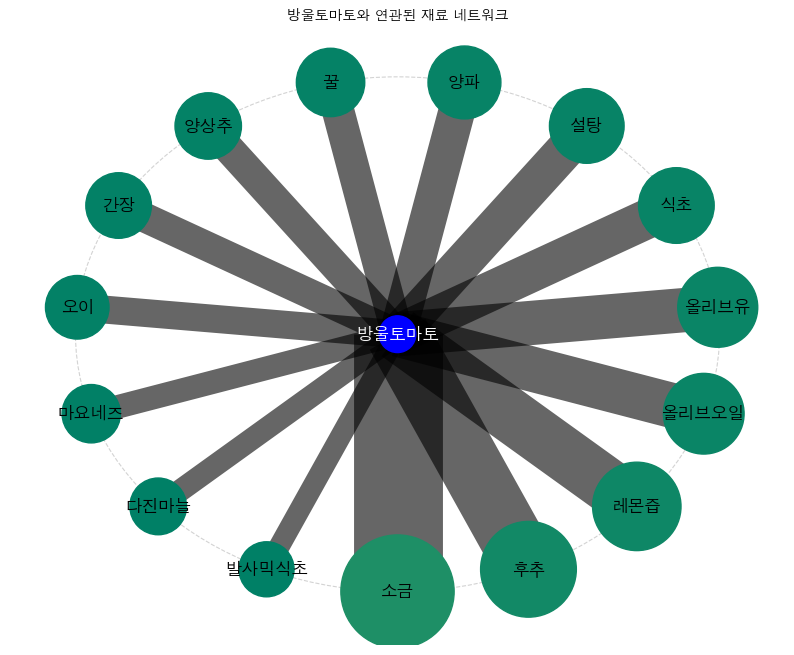

In [24]:
# 특정 재료와 연관된 재료 계산
target_ingredient = "방울토마토"
associations = calculate_associations(df_salads, target_ingredient)
sorted_associations = sorted(associations, key=lambda x: x[-1], reverse=True)[:15]

# 연관성 네트워크 시각화
visualize_associations_as_network(sorted_associations, target_ingredient)

In [25]:
sorted_associations

[(('방울토마토', '소금'), 343),
 (('방울토마토', '후추'), 245),
 (('레몬즙', '방울토마토'), 209),
 (('방울토마토', '올리브오일'), 174),
 (('방울토마토', '올리브유'), 171),
 (('방울토마토', '식초'), 153),
 (('방울토마토', '설탕'), 149),
 (('방울토마토', '양파'), 142),
 (('꿀', '방울토마토'), 125),
 (('방울토마토', '양상추'), 118),
 (('간장', '방울토마토'), 115),
 (('방울토마토', '오이'), 108),
 (('마요네즈', '방울토마토'), 91),
 (('다진마늘', '방울토마토'), 86),
 (('발사믹식초', '방울토마토'), 81)]

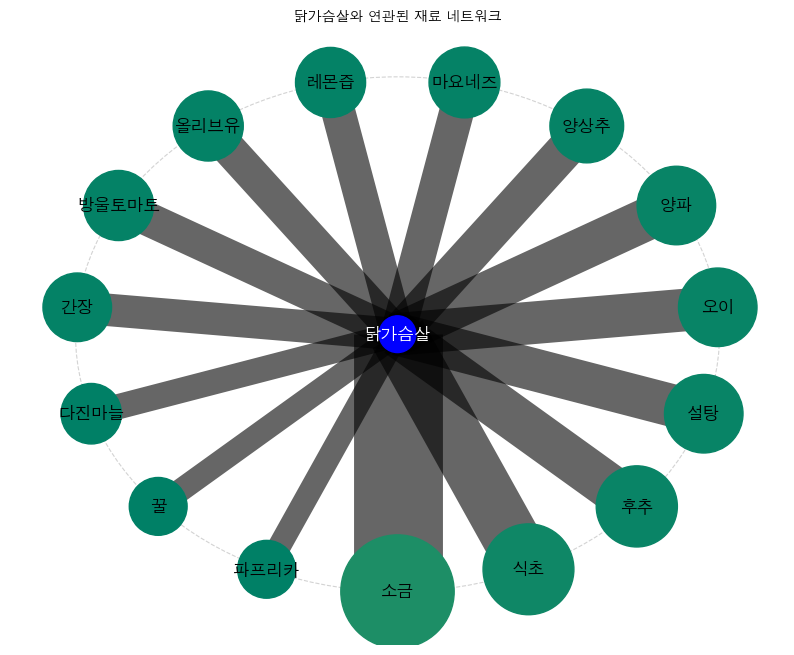

In [26]:
# 특정 재료와 연관된 재료 계산
target_ingredient = "닭가슴살"
associations = calculate_associations(df_salads, target_ingredient)
sorted_associations = sorted(associations, key=lambda x: x[-1], reverse=True)[:15]

# 연관성 네트워크 시각화
visualize_associations_as_network(sorted_associations, target_ingredient)

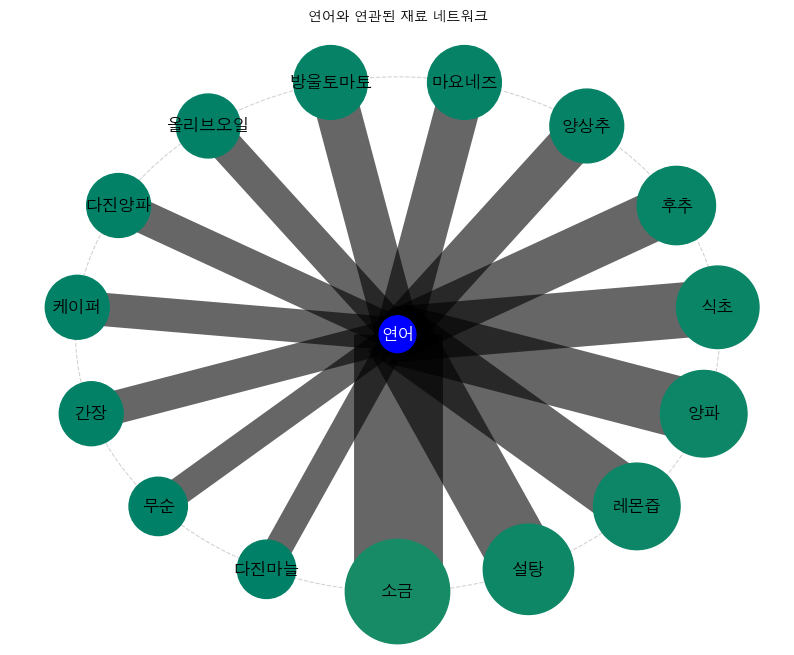

In [27]:
# 특정 재료와 연관된 재료 계산
target_ingredient = "연어"
associations = calculate_associations(df_salads, target_ingredient)
sorted_associations = sorted(associations, key=lambda x: x[-1], reverse=True)[:15]

# 연관성 네트워크 시각화
visualize_associations_as_network(sorted_associations, target_ingredient)

In [28]:
df_salads['CKG_NM'].value_counts().head(20)

CKG_NM
감자샐러드        163
샐러드          129
닭가슴살샐러드       98
두부샐러드         87
과일샐러드         71
단호박샐러드        58
고구마샐러드        58
양배추샐러드        55
감자샐러드샌드위치     52
연어샐러드         51
코울슬로          47
콘샐러드          43
마카로니샐러드       40
콥샐러드          37
샐러드파스타        35
당근라페          35
연근샐러드         32
과일사라다         28
토마토샐러드        28
리코타치즈샐러드      28
Name: count, dtype: int64

In [29]:
df_salads[df_salads['CKG_NM'] == '감자샐러드'][['재료','양']]

,재료,양
42,"[감자(中크기), 프랑크소시지, 푸른잎 채소, 홀그레인 머스타드, 다진마늘, 올리브...","[1개, 2개, 적당히, 2Ts, 1ts, 1Ts, 2.5Ts, 약간, 약간, 약간]"
49,"[감자, 삶은계란, 사과, 장식용 슬라이스치즈, 딸기or방울토마토(장식용), 브로콜...","[3개, 2개, 1개, 1장, 약간, 2송이, 1/2작은술, 2큰술, 2큰술]"
84,"[감자(大), 오이, 김밥햄, 사과(小), 달걀, 소금, 후추, 마요네즈]","[3개, 1/2개, 1/3개, 1개, 3개, 약간, 약간, 취향껏]"
85,"[감자 큰걸로, 양파, 옥수수, 당근, 브로콜리, 파프리카, 땅콩 마요네즈, 구운소...","[2개, , , , , , 4큰술, 1작은술, 5g]"
103,"[감자, 스위트콘, 오이, 사과, 양파, 마요네즈, 소금, 후추, 레몬즙]","[2개(중), 1.5T, 1/3개, 1/4개, 1/8개, 2T, 약간, 약간, 약간]"
...,...,...
4444,"[감자, 당근, 비트, 피망, 달걀, 소금, 후추, 마요네즈]","[4개, 1/4개, 약간, 1/4개, 2개, 약간, 약간, 1.5T]"
4477,"[감자, 소금, 양배추, 소금, 당근, 적양파, 마요네즈, 꿀, 후추, 방울토마토]","[13개, 1/2큰술, , , 1/2개, 1/2개, 3큰술+, 1큰술, , ]"
4523,"[감자 3개, 계란 2개, 당근, 양파, 오이피클, 마요네즈, 올리고당, 소금, 후...","[291g, 105g, 30g, 28g, 44g, 4큰술, 2큰술, 0.25작은술,..."
4530,"[감자, 미니단호박, 적양파, 소금, 후추, 마요네즈, 올리브오일, 매실액, 꿀]","[4개, 1개, 1개, , , 2큰술, 1큰술, 1큰술, 1큰술]"


---

### (1-3) 재료 재분류

In [29]:
import re

# 샐러드 재료 텍스트 파싱 함수
def parse_ingredients(raw_text):
    sections = re.split(r"\[(.*?)\]", raw_text)
    result = []

    # 소스 관련 키워드
    sauce_keywords = {'간장', '올리브유', '참기름', '마요네즈', '식초', '드레싱', '후추', '머스터드', '설탕',
                      '고춧가루', '레몬즙', '오일', '와사비', '겨자', '양념','소금', '소스', '양념장', '소스류', '드레싱류'}

    current_section = "기타"

    for i in range(1, len(sections), 2):
        section_name = sections[i]
        current_section = section_name
        items_text = sections[i + 1] if i + 1 < len(sections) else ""
        items = items_text.split('|')

        for item in items:
            item = item.strip()
            if not item:
                continue
            parts = item.rsplit(' ', 1)
            name, amount = parts if len(parts) == 2 else (parts[0], '')
            name = name.strip()
            amount = amount.strip()
            category = "소스" if any(kw in name for kw in sauce_keywords) or "양념" in current_section or "드레싱" in current_section else "재료"
            result.append({'section': current_section, 'category': category, 'ingredient': name, 'amount': amount})
    return result

# 예시: 데이터프레임 df 에서 flatten
def flatten_salad_data(df, material_col='CKG_MTRL_CN', menu_col='CKG_NM', view_col='INQ_CNT'):
    parsed_all = []

    for idx, row in df[[material_col, menu_col, view_col]].dropna().iterrows():
        ingredients = parse_ingredients(row[material_col])
        for ing in ingredients:
            ing['menu_name'] = row[menu_col]
            ing['views'] = row[view_col]
            parsed_all.append(ing)

    return pd.DataFrame(parsed_all)

# CKG_MTRL_CN에 대해 파싱 적용
parsed_results = df_salads['CKG_MTRL_CN'].dropna().apply(parse_ingredients)

# 결과를 병합하여 하나의 DataFrame으로 정리
flattened = [item for sublist in parsed_results for item in sublist]
df_parsed = pd.DataFrame(flattened)
df_parsed_salads =  flatten_salad_data(df_salads)

In [30]:
df_parsed_salads['ingredient'].value_counts().head(20)

ingredient
소금       2421
설탕       1418
마요네즈     1353
후추       1240
식초       1232
양파       1118
레몬즙      1110
오이        969
올리브유      715
간장        685
꿀         641
방울토마토     634
당근        619
올리브오일     616
양상추       519
다진마늘      516
참기름       503
사과        450
토마토       412
파프리카      366
Name: count, dtype: int64

In [31]:
name = '소금'
f1 = df_parsed_salads['ingredient'] == name
# f2 = df_parsed_salads['category'] != '소스'
df_parsed_salads[f1]

,section,category,ingredient,amount,menu_name,views
7,소스,소스,소금,0.5스푼,토마토카프레제샐러드,83933
19,양념,소스,소금,0.5스푼,샐러드오므라이스,2323
26,양념,소스,소금,0.3작은술,연어계란샐러드,4959
31,재료,소스,소금,0.5작은술,연두부샐러드,8182
35,양념,소스,소금,0.2작은술,연두부샐러드,8182
...,...,...,...,...,...,...
44490,재료,소스,소금,조금,포테토샐러드,37
44514,발사믹 소스,소스,소금,조금,들기름두부구이,127
44543,재료,소스,소금,약간,두부면샐러드,87
44558,필수 재료,소스,소금,약간,쉬림프사워크림샐러드,10208


In [32]:
f1 = df_salads['RCP_TTL'] == '블루베리샐러드with아보카도 드레싱'
df_salads[f1]['CKG_MTRL_CN'].values[0]

'[재료] 생블루베리| 양배추| 견과류 [아보카도드레싱] 아보카도스프레드| 양파| 토마토| 들께가루| 사과청or사과주스| 매실액| 식초+레몬즙| 올리브오일'

In [33]:
for name in df_parsed_salads['ingredient'].value_counts().head(20).index:
    cat_n = len(df_parsed_salads[df_parsed_salads['ingredient'] == name]['category'].value_counts())
    if cat_n != 1:
        print(f'{name}: ', cat_n)

양파:  2
오이:  2
꿀:  2
방울토마토:  2
당근:  2
다진마늘:  2
사과:  2
토마토:  2
파프리카:  2


In [34]:
df_parsed_salads[df_parsed_salads['category'] == '재료']['ingredient'].value_counts().head(50)

ingredient
양파       1074
오이        967
방울토마토     633
당근        617
양상추       519
사과        438
토마토       408
파프리카      363
양배추       340
감자        319
꿀         296
계란        256
닭가슴살      216
다진마늘      212
물         206
두부        205
어린잎채소     176
달걀        168
마늘        166
올리고당      161
후춧가루      156
견과류       155
아보카도      153
브로콜리      143
상추        141
샐러드채소     137
맛살        135
크래미       134
식빵        131
치커리       130
통깨        125
딸기        115
깻잎        111
레몬        111
우유         99
베이컨        94
파슬리가루      92
식용유        91
고구마        89
버터         85
새우         85
귤          84
새싹채소       82
호두         82
단호박        81
블랙올리브      80
건포도        78
바나나        77
다진 마늘      76
매실청        75
Name: count, dtype: int64

In [35]:
df_parsed_salads[df_parsed_salads['category'] == '재료']['ingredient'].value_counts().head(20)

ingredient
양파       1074
오이        967
방울토마토     633
당근        617
양상추       519
사과        438
토마토       408
파프리카      363
양배추       340
감자        319
꿀         296
계란        256
닭가슴살      216
다진마늘      212
물         206
두부        205
어린잎채소     176
달걀        168
마늘        166
올리고당      161
Name: count, dtype: int64

In [36]:
import pandas as pd
import plotly.express as px

# Top 50 메인 재료 (소스 제외)
top_main_ingredients = (
    df_parsed_salads[df_parsed_salads['category'] == '재료']
    .groupby('ingredient')['menu_name']
    .count()
    .sort_values(ascending=False)
    .head(50)
    .reset_index(name='count')
)

# Plotly로 바 그래프 시각화
fig = px.bar(top_main_ingredients,
             x='ingredient', y='count',
             title='Top 50 메인 재료 사용 빈도',
             labels={'ingredient': '재료명', 'count': '사용된 횟수'},
             height=600)
fig.update_layout(xaxis_tickangle=45)
fig.show()

In [37]:
def get_top_recipes_by_ingredient(df, ingredient, top_n=10):
    filtered = df[(df['category'] == '재료') & (df['ingredient'] == ingredient)]
    top_menus = (
        filtered.groupby('menu_name')['views']
        .max()
        .sort_values(ascending=False)
        .head(top_n)
        .reset_index()
    )

    fig = px.bar(top_menus,
                 x='menu_name', y='views',
                 title=f'"{ingredient}" 포함 인기 샐러드 Top {top_n}',
                 labels={'menu_name': '메뉴명', 'views': '조회수'},
                 height=500)
    fig.update_layout(xaxis_tickangle=45)
    return fig

# 예시: 닭가슴살 들어간 인기 레시피
fig = get_top_recipes_by_ingredient(df_parsed_salads, '감자')
fig.show()

### (2-1) 연관성 분석 2

In [30]:
df_salads.shape#.sort_values('INQ_CNT', ascending=False).head(500)[['RCP_TTL','INQ_CNT']]

(4634, 20)

In [31]:
df_ingr_nx = df_salads.sort_values('INQ_CNT', ascending=False).head(500)#[['RCP_TTL','INQ_CNT']]

In [32]:
from itertools import combinations

ingredient_lists = df_ingr_nx['재료'].to_list()

co_occurrence = pd.DataFrame(
    [pair for lst in ingredient_lists for pair in combinations(sorted(lst), 2)],
    columns=['source', 'target']
).value_counts().reset_index(name='weight')

In [62]:
df_ingr_nx['재료']

931                      [감자, 계란, 당근, 양파, 오이, 마요네즈, 머스터드]
1533    [옥수수통조림, 빨간 파프리카, 노란 파프리카, 양파, 마요네즈, 식초, 설탕, 소...
407      [감자, 계란, 오이, 맛살, 마요네즈, 떠먹는 요구르트, 소금, 후추, 머스타드소스]
837     [양상추, 어린잎채소, 당근, 양파, 방울토마토 5개 ?, 진간장, 사과식초, 설탕...
1556    [양배추, 파프리카, 캔옥수수, 식초, 설탕, 소금, 마요네즈, 식초, 설탕, 소금...
                              ...                        
374            [오이, 소금, 빨강파프리카, 노랑파프리카, 크래미, 케챂, 마요네즈, 꿀]
449     [딸기, 사과, 파프리카, 적겨자, 로메인, 치커리, 블루베리, 아몬드, 호두, 해...
2012    [닭가슴살, 부추, 파프리카, 양파, 당근, 오이, 새싹채소, 설탕, 올리고당, 겨...
656     [양배추, 양파, 파프리카, 콘옥수수, 올리브오일, 설탕, 소금, 식초, 마요네즈,...
2828    [감자, 삶은계란, 당근, 적양파, 견과류냉장고재료사용, 소금, 소금, 설탕, 머스...
Name: 재료, Length: 500, dtype: object

In [60]:
co_occurrence

,source,target,weight
0,설탕,소금,143
1,마요네즈,소금,137
2,설탕,식초,136
3,소금,후추,121
4,소금,식초,118
...,...,...,...
12651,두부,레몬,1
12652,두부,마요네즈,1
12653,두부,맛술,1
12654,두부,머스터드소스,1


In [33]:
len(co_occurrence)

12656

In [34]:
import networkx as nx

G = nx.from_pandas_edgelist(co_occurrence, 
                           source='source', 
                           target='target', 
                           edge_attr='weight')

# 노드 강도 계산(가중치 합계)
node_strength = dict(G.degree(weight='weight'))
print(sorted(node_strength.items(), key=lambda x: -x[1]))

[('소금', 2640), ('설탕', 2016), ('마요네즈', 1872), ('식초', 1716), ('양파', 1264), ('후추', 1262), ('오이', 1247), ('레몬즙', 1067), ('간장', 995), ('올리브유', 847), ('당근', 727), ('다진마늘', 711), ('양상추', 705), ('방울토마토', 641), ('꿀', 591), ('참기름', 545), ('파프리카', 513), ('연겨자', 468), ('양배추', 416), ('사과', 371), ('올리고당', 349), ('물', 341), ('후춧가루', 339), ('다진양파', 336), ('토마토', 335), ('올리브오일', 320), ('마늘', 314), ('매실청', 312), ('닭가슴살', 308), ('발사믹식초', 304), ('맛살', 301), ('통깨', 301), ('감자', 297), ('달걀', 252), ('계란', 231), ('다진 양파', 206), ('무순', 201), ('견과류', 195), ('우유', 195), ('크래미', 186), ('맛술', 184), ('머스터드', 173), ('어린잎채소', 157), ('다진 마늘', 152), ('치커리', 149), ('깨', 142), ('바나나', 142), ('머스터드소스', 138), ('노랑파프리카', 135), ('빨강파프리카', 135), ('새싹채소', 132), ('블랙올리브', 130), ('상추', 125), ('밥', 122), ('베이비채소', 120), ('플레인요거트', 119), ('청주', 119), ('적양파', 118), ('베이컨', 118), ('요거트', 116), ('두부', 115), ('깨소금', 113), ('해파리', 104), ('레몬', 103), ('통후추', 103), ('브로콜리', 103), ('모닝빵', 102), ('마카로니', 100), ('샐러드채소', 99), ('새송이버섯', 99),

In [35]:
len(node_strength)

1014

In [40]:
from itertools import combinations
import networkx as nx
from pyvis.network import Network

# 1. 데이터 준비
ingredient_lists = df_ingr_nx['재료'].to_list()

# 2. 공동발생(연결) 데이터프레임 생성
pairs = []
for lst in ingredient_lists:
    for pair in combinations(sorted(lst), 2):
        pairs.append(pair)
co_occurrence = pd.DataFrame(pairs, columns=['source', 'target'])
co_occurrence = co_occurrence.value_counts().reset_index(name='weight')

# 3. 네트워크 그래프 생성
G = nx.from_pandas_edgelist(
    co_occurrence, 
    source='source', 
    target='target', 
    edge_attr='weight'
)

# 4. 노드 강도(연결 가중치 합) 계산
node_strength = dict(G.degree(weight='weight'))

# 5. Pyvis로 시각화
net = Network(height='600px', width='100%', notebook=False)  # notebook=False로 설정

# 노드 추가 (강도에 따라 크기 조절)
for node in G.nodes:
    net.add_node(node, size=10 + node_strength[node]*5, title=f"{node} (연결강도: {node_strength[node]})")

# 엣지 추가 (가중치에 따라 굵기 조절)
for edge in G.edges(data=True):
    net.add_edge(edge[0], edge[1], value=edge[2]['weight'], title=f"공동발생: {edge[2]['weight']}")

# 6. HTML 파일로 저장 및 브라우저에서 열기
net.save_graph('ingredient_network.html')
print("ingredient_network.html 파일이 생성되었습니다. 브라우저로 열어보세요.")


ingredient_network.html 파일이 생성되었습니다. 브라우저로 열어보세요.


In [58]:
import networkx as nx
from itertools import combinations
import pandas as pd

# 재료 데이터 (예시)
ingredient_lists = df_ingr_nx['재료'].to_list()

# 공동발생 네트워크 생성
pairs = [pair for lst in ingredient_lists for pair in combinations(sorted(lst), 2)]
co_occurrence = pd.DataFrame(pairs, columns=['source', 'target'])
co_occurrence = co_occurrence.value_counts().reset_index(name='weight')

# 네트워크 그래프 생성
G = nx.from_pandas_edgelist(co_occurrence, 
                           source='source', 
                           target='target', 
                           edge_attr='weight')

# 가중 연결 강도 계산 및 상위 100개 추출
node_strength = dict(G.degree(weight='weight'))
top_100_nodes = sorted(node_strength.items(), 
                      key=lambda x: -x[1])[:10]  # 연결 강도 기준 내림차순 정렬
top_100_nodes = [node for node, _ in top_100_nodes]

# 서브그래프 생성
subG = G.subgraph(top_100_nodes)


In [59]:
from pyvis.network import Network

# 네트워크 초기화 (notebook=False 필수)
net = Network(height='800px', width='100%', notebook=False)

# # ForceAtlas2 레이아웃으로 초기 위치 계산
# pos = nx.forceatlas2_layout(G, seed=42, scaling_ratio=10)

# # 계산된 위치를 Pyvis에 적용
# for node in subG.nodes:
#     net.add_node(node, x=pos[node][0]*1000, y=pos[node][1]*1000)  # 좌표 스케일 조정

# 노드 추가 (크기 = 연결 강도 비례)
for node in subG.nodes():
    net.add_node(node, 
                size=3 + node_strength[node]*0.001,  # 크기 조정 계수
                title=f"{node}\n연결강도: {node_strength[node]}")

# 엣지 추가 (굵기 = 가중치 비례)
for u, v, data in subG.edges(data=True):
    net.add_edge(u, v, 
                value=data['weight'], 
                title=f"공동사용: {data['weight']}회")

# 시각화 저장
net.save_graph('top100_ingredients.html')

In [54]:
net = Network(height='800px', width='100%', 
             notebook=False, 
             bgcolor='#ffffff', font_color='black',
             cdn_resources='in_line',
             dim=2)  # 핵심: 2D 차원 지정[4]

# 노드/엣지 추가 코드
# ...
net.save_graph('2d_network.html')

TypeError: Network.__init__() got an unexpected keyword argument 'dim'

---

## Archived

In [ ]:
# 썸트렌드

### [1] 배달 데이터

In [7]:
base_loc = '/Users/byunghoonlee/Documents/Side Projects/Data Projects/Inner Circle 2025/data/w3/'
card_loc = base_loc+'cards/'

ls_cards = [c for c in os.listdir(card_loc) if '.csv' in c]

df_card = pd.DataFrame()
for f in ls_cards:
    df_tmp = pd.read_csv(f'{card_loc}KGU_3rd_ORIGIN_KGUDSTNORDER_20210101000000.csv', header=None)
    df_card = pd.concat([df_card, df_tmp], axis=0)

card_cols =  ['DE', 'HRLY_TIME', 'DLVR_STORE_INDUTY_NM','DLVR_DSTN_BRTC_NM','DLVR_DSTN_SIGNGU_NM','OREDER_CASCNT']
df_card.columns = card_cols

In [12]:
# 컬럼 의미
dic_cols = {'DE':'주문일자', 'HRLY_TIME':'주문시간대', 'DLVR_STORE_INDUTY_NM':'업종','DLVR_DSTN_BRTC_NM':'광역시도','DLVR_DSTN_SIGNGU_NM':'시군구','OREDER_CASCNT':'주문건수'}
dic_cols

{'DE': '주문일자',
 'HRLY_TIME': '주문시간대',
 'DLVR_STORE_INDUTY_NM': '업종',
 'DLVR_DSTN_BRTC_NM': '광역시도',
 'DLVR_DSTN_SIGNGU_NM': '시군구',
 'OREDER_CASCNT': '주문건수'}

In [15]:
df_card['DLVR_STORE_INDUTY_NM'].unique()

array(['돈까스/일식', '배달전문업체', '분식', '아시안/양식', '야식', '족발/보쌈', '중식', '찜탕',
       '치킨', '카페/디저트', '패스트푸드', '피자', '한식', '회', '심부름', '도시락'],
      dtype=object)

In [20]:
df_card['DLVR_STORE_INDUTY_NM'].value_counts()

DLVR_STORE_INDUTY_NM
카페/디저트    386358
한식        344859
치킨        322029
돈까스/일식    278721
분식        248064
패스트푸드     228987
찜탕        190824
피자        183603
야식        176337
족발/보쌈     164886
중식        162756
회         106146
아시안/양식    102456
배달전문업체     84915
도시락        65931
심부름        31266
Name: count, dtype: int64

In [25]:
f1 = df_card['DLVR_STORE_INDUTY_NM'] == '도시락'
f2 = df_card['DLVR_DSTN_SIGNGU_NM'] == '강남구'
df_card[f1&f2]

,DE,HRLY_TIME,DLVR_STORE_INDUTY_NM,DLVR_DSTN_BRTC_NM,DLVR_DSTN_SIGNGU_NM,OREDER_CASCNT


### [2] 업종별 위치/개업수/폐업률 데이터

In [38]:
# 전체 > 분류 가져오기용
floc='/Users/byunghoonlee/Documents/Side Projects/Data Projects/Inner Circle 2025/data/w2/소상공인시장진흥공단_상가(상권)정보_20241231/소상공인시장진흥공단_상가(상권)정보_대전_202412.csv'
df_shops1 = pd.read_csv(floc)

In [58]:
f1 = df_shops1['상권업종대분류명'] == '음식'
df_res = df_shops1[f1]

In [60]:
df_res[['상권업종대분류명','상권업종중분류명','상권업종소분류명']]

,상권업종대분류명,상권업종중분류명,상권업종소분류명
2,음식,비알코올,카페
3,음식,구내식당·뷔페,구내식당
4,음식,중식,중국집
8,음식,비알코올,카페
9,음식,기타 간이,떡/한과
...,...,...,...
80581,음식,한식,백반/한정식
80582,음식,한식,백반/한정식
80584,음식,한식,백반/한정식
80585,음식,한식,돼지고기 구이/찜


In [155]:
df_res['상권업종소분류명'].unique()

array(['카페', '구내식당', '중국집', '떡/한과', '돼지고기 구이/찜', '백반/한정식', '치킨', '요리 주점',
       '횟집', '김밥/만두/분식', '아이스크림/빙수', '피자', '생맥주 전문', '토스트/샌드위치/샐러드',
       '일식 면 요리', '일식 회/초밥', '일반 유흥 주점', '국/탕/찌개류', '국수/칼국수',
       '그 외 기타 간이 음식점', '소고기 구이/찜', '빵/도넛', '곱창 전골/구이', '족발/보쌈', '경양식',
       '닭/오리고기 구이/찜', '마라탕/훠궈', '버거', '해산물 구이/찜', '일식 카레/돈가스/덮밥',
       '기타 서양식 음식점', '파스타/스테이크', '베트남식 전문', '냉면/밀면', '전/부침개', '기타 한식 음식점',
       '복 요리 전문', '무도 유흥 주점', '뷔페', '패밀리레스토랑', '기타 동남아식 전문', '기타 일식 음식점'],
      dtype=object)

In [152]:
df_res.columns

Index(['상가업소번호', '상호명', '지점명', '상권업종대분류코드', '상권업종대분류명', '상권업종중분류코드',
       '상권업종중분류명', '상권업종소분류코드', '상권업종소분류명', '표준산업분류코드', '표준산업분류명', '시도코드',
       '시도명', '시군구코드', '시군구명', '행정동코드', '행정동명', '법정동코드', '법정동명', '지번코드',
       '대지구분코드', '대지구분명', '지번본번지', '지번부번지', '지번주소', '도로명코드', '도로명', '건물본번지',
       '건물부번지', '건물관리번호', '건물명', '도로명주소', '구우편번호', '신우편번호', '동정보', '층정보',
       '호정보', '경도', '위도', 'key'],
      dtype='object')

In [153]:
df_res[['도로명코드','도로명주소']]

,도로명코드,도로명주소
2,302304304066,대전광역시 대덕구 대전로1020번길 66
3,302303168018,대전광역시 대덕구 신일동로 105
4,302004301061,대전광역시 유성구 궁동로14번길 14
8,302003342030,대전광역시 유성구 상대동로 44
9,301703166032,대전광역시 서구 복수남로 36
...,...,...
80581,301404295202,대전광역시 중구 대흥로127번길 11
80582,301704298170,대전광역시 서구 대덕대로185번길 14
80584,301704298055,대전광역시 서구 계룡로326번길 9
80585,301704298171,대전광역시 서구 대덕대로195번길 58


In [148]:
df_res['도로명주소']

2        대전광역시 대덕구 대전로1020번길 66
3            대전광역시 대덕구 신일동로 105
4          대전광역시 유성구 궁동로14번길 14
8             대전광역시 유성구 상대동로 44
9              대전광역시 서구 복수남로 36
                  ...          
80581      대전광역시 중구 대흥로127번길 11
80582     대전광역시 서구 대덕대로185번길 14
80584       대전광역시 서구 계룡로326번길 9
80585     대전광역시 서구 대덕대로195번길 58
80588     대전광역시 중구 계백로1565번길 30
Name: 도로명주소, Length: 24838, dtype: object

In [63]:
f1 = df_res['상권업종소분류명'] == '토스트/샌드위치/샐러드'
df_res[f1]['상권업종중분류명'].unique()

array(['기타 간이'], dtype=object)

In [167]:
df_res[['상호명', '지점명','도로명주소','신우편번호','key']]

,상호명,지점명,도로명주소,신우편번호,key
2,느낌,NaN,대전광역시 대덕구 대전로1020번길 66,34435,느낌34435
3,맛있는밥상,NaN,대전광역시 대덕구 신일동로 105,34324,맛있는밥상34324
4,동해원,NaN,대전광역시 유성구 궁동로14번길 14,34137,동해원34137
8,로우프레소,NaN,대전광역시 유성구 상대동로 44,34199,로우프레소34199
9,동방떡집,NaN,대전광역시 서구 복수남로 36,35412,동방떡집35412
...,...,...,...,...,...
80581,밥심,NaN,대전광역시 중구 대흥로127번길 11,34919,밥심34919
80582,붱,NaN,대전광역시 서구 대덕대로185번길 14,35230,붱35230
80584,신가장수촌,NaN,대전광역시 서구 계룡로326번길 9,35275,신가장수촌35275
80585,상록회관연탄구이대전,둔산점,대전광역시 서구 대덕대로195번길 58,35230,상록회관연탄구이대전35230


In [169]:
f1 = df_dj['사업장명'] == '신가장수촌'
df_dj[f1][['사업장명','도로명전체주소','소재지우편번호','도로명우편번호','key']]

,사업장명,도로명전체주소,소재지우편번호,도로명우편번호,key
1379294,신가장수촌,대전광역시 서구 계룡로326번길 7 (갈마동),302-805,35275.0,신가장수촌35275.0
2140398,신가장수촌,"대전광역시 서구 신갈마로 152, 1층 (갈마동)",302-807,35277.0,신가장수촌35277.0


In [173]:
df_dj['key'] = df_dj['사업장명'] + df_dj['도로명우편번호'].apply(lambda x: 'null' if str(x) =='nan' else str(int(x)))

/var/folders/xj/2s3xtsx155s338l8v9g7k_wh0000gn/T/ipykernel_2195/3229649078.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_dj['key'] = df_dj['사업장명'] + df_dj['도로명우편번호'].apply(lambda x: 'null' if str(x) =='nan' else str(int(x)))


In [177]:
df_dj.columns

Index(['번호', '개방서비스명', '개방서비스아이디', '개방자치단체코드', '관리번호', '인허가일자', '인허가취소일자',
       '영업상태구분코드', '영업상태명', '상세영업상태코드', '상세영업상태명', '폐업일자', '휴업시작일자', '휴업종료일자',
       '재개업일자', '소재지전화', '소재지면적', '소재지우편번호', '소재지전체주소', '도로명전체주소', '도로명우편번호',
       '사업장명', '최종수정시점', '데이터갱신구분', '데이터갱신일자', '업태구분명', '좌표정보x(epsg5174)',
       '좌표정보y(epsg5174)', '위생업태명', '남성종사자수', '여성종사자수', '영업장주변구분명', '등급구분명',
       '급수시설구분명', '총직원수', '본사직원수', '공장사무직직원수', '공장판매직직원수', '공장생산직직원수',
       '건물소유구분명', '보증액', '월세액', '다중이용업소여부', '시설총규모', '전통업소지정번호', '전통업소주된음식',
       '홈페이지', 'Unnamed: 47', '건물관리번호', 'key'],
      dtype='object')

In [178]:
df_res_merged = pd.merge(df_res[['상호명','상권업종소분류명','도로명주소','key']], df_dj[['사업장명','인허가일자','인허가취소일자','폐업일자','key']], how='left')

In [179]:
df_res_merged

,상호명,상권업종소분류명,도로명주소,key,사업장명,인허가일자,인허가취소일자,폐업일자
0,느낌,카페,대전광역시 대덕구 대전로1020번길 66,느낌34435,NaN,NaN,NaN,NaN
1,맛있는밥상,구내식당,대전광역시 대덕구 신일동로 105,맛있는밥상34324,NaN,NaN,NaN,NaN
2,동해원,중국집,대전광역시 유성구 궁동로14번길 14,동해원34137,NaN,NaN,NaN,NaN
3,로우프레소,카페,대전광역시 유성구 상대동로 44,로우프레소34199,NaN,NaN,NaN,NaN
4,동방떡집,떡/한과,대전광역시 서구 복수남로 36,동방떡집35412,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...
25294,밥심,백반/한정식,대전광역시 중구 대흥로127번길 11,밥심34919,NaN,NaN,NaN,NaN
25295,붱,백반/한정식,대전광역시 서구 대덕대로185번길 14,붱35230,붱,2005-11-23,NaN,NaN
25296,신가장수촌,백반/한정식,대전광역시 서구 계룡로326번길 9,신가장수촌35275,신가장수촌,1993-04-22,NaN,2021-12-31
25297,상록회관연탄구이대전,돼지고기 구이/찜,대전광역시 서구 대덕대로195번길 58,상록회관연탄구이대전35230,NaN,NaN,NaN,NaN


---

In [ ]:
# import requests
# import pandas as pd
# from xml.etree import ElementTree  # XML 파싱용

# # API 인증 정보 입력 (※ 반드시 발급받은 본인 키로 교체)
# API_KEY = "5637a19517984dcb91c1"  # 식품안전나라 OpenAPI 인증키
# SERVICE_ID = "I2819"      # 서비스 ID (폐업정보)

# def fetch_food_closures(start_idx=1, end_idx=5):
#     """API로 폐업정보 데이터 가져오기"""
#     base_url = f"http://openapi.foodsafetykorea.go.kr/api/{API_KEY}/{SERVICE_ID}/xml/{start_idx}/{end_idx}"
    
#     try:
#         response = requests.get(base_url)
#         response.raise_for_status()  # HTTP 오류 체크
        
#         # XML 파싱
#         root = ElementTree.fromstring(response.content)
        
#         # 데이터 추출
#         data = []
#         for item in root.findall('.//row'):
#             data.append({
#                 '인허가번호': item.findtext('LCNS_NO'),
#                 '업소명': item.findtext('BSSH_NM'),
#                 '대표자명': item.findtext('PRSDNT_NM'),
#                 '업종': item.findtext('INDUTY_NM'),
#                 '허가일자': item.findtext('PRMS_DT'),
#                 '폐업일자': item.findtext('CLSBIZ_DT'),
#                 '폐업상태': item.findtext('CLSBIZ_DVS_CD_NM'),
#                 '주소': item.findtext('LOCP_ADDR'),
#                 '기관명': item.findtext('INSTT_NM')
#             })
            
#         return pd.DataFrame(data)
    
#     except Exception as e:
#         print(f"에러 발생: {e}")
#         return pd.DataFrame()

# # 데이터 수집 실행 (예시: 1~1000건)
# df = fetch_food_closures(1, 1000)  # 최대 1000건까지 한 번에 요청 가능

# # 결과 확인 및 저장
# if not df.empty:
#     print(f"총 {len(df)}건 데이터 수집 완료")
#     df.to_csv("food_closures.csv", index=False, encoding='utf-8-sig')
#     print("CSV 파일 저장 완료")
# else:
#     print("데이터 수집 실패")


---

In [39]:
# 음식만
floc='/Users/byunghoonlee/Documents/Side Projects/Data Projects/Inner Circle 2025/data/w2/전국일반음식점표준데이터_240326.csv'
df_shops2 = pd.read_csv(floc, encoding='cp949')

df_shops2['건물관리번호'] = df_shops2['관리번호'].apply(lambda x: str(x).replace('-',''))

/var/folders/xj/2s3xtsx155s338l8v9g7k_wh0000gn/T/ipykernel_2195/3388934875.py:2: DtypeWarning: Columns (11,17,39,44,45) have mixed types. Specify dtype option on import or set low_memory=False.
  df_shops2 = pd.read_csv(floc, encoding='cp949')


In [40]:
df_shops2.columns

Index(['번호', '개방서비스명', '개방서비스아이디', '개방자치단체코드', '관리번호', '인허가일자', '인허가취소일자',
       '영업상태구분코드', '영업상태명', '상세영업상태코드', '상세영업상태명', '폐업일자', '휴업시작일자', '휴업종료일자',
       '재개업일자', '소재지전화', '소재지면적', '소재지우편번호', '소재지전체주소', '도로명전체주소', '도로명우편번호',
       '사업장명', '최종수정시점', '데이터갱신구분', '데이터갱신일자', '업태구분명', '좌표정보x(epsg5174)',
       '좌표정보y(epsg5174)', '위생업태명', '남성종사자수', '여성종사자수', '영업장주변구분명', '등급구분명',
       '급수시설구분명', '총직원수', '본사직원수', '공장사무직직원수', '공장판매직직원수', '공장생산직직원수',
       '건물소유구분명', '보증액', '월세액', '다중이용업소여부', '시설총규모', '전통업소지정번호', '전통업소주된음식',
       '홈페이지', 'Unnamed: 47'],
      dtype='object')

In [156]:
f1 = df_shops2['도로명전체주소'].apply(lambda x: str(x)[:2] == '대전')
df_dj = df_shops2[f1]

In [114]:
f1 = df_shops2['사업장명'].apply(lambda x: '올미' in str(x))
f2 = df_shops2['도로명전체주소'].apply(lambda x: str(x)[:2] == '대전')
df_tmp = df_shops2[f1&f2]

In [115]:
df_tmp

,번호,개방서비스명,개방서비스아이디,개방자치단체코드,관리번호,인허가일자,인허가취소일자,영업상태구분코드,영업상태명,상세영업상태코드,...,건물소유구분명,보증액,월세액,다중이용업소여부,시설총규모,전통업소지정번호,전통업소주된음식,홈페이지,Unnamed: 47,건물관리번호
128265,128266,일반음식점,07_24_04_P,3670000,3670000-101-2017-00298,2017-07-18,NaN,3,폐업,2,...,NaN,NaN,NaN,N,0.00,NaN,NaN,NaN,NaN,3670000101201700298
1544413,1544414,일반음식점,07_24_04_P,3650000,3650000-101-2020-00116,2020-07-08,NaN,1,영업/정상,1,...,NaN,NaN,NaN,Y,178.17,NaN,NaN,NaN,NaN,3650000101202000116
1544414,1544415,일반음식점,07_24_04_P,3650000,3650000-101-2020-00115,2020-07-08,NaN,1,영업/정상,1,...,NaN,0.0,0.0,Y,175.10,NaN,NaN,NaN,NaN,3650000101202000115
1544415,1544416,일반음식점,07_24_04_P,3650000,3650000-101-2020-00114,2020-07-08,NaN,1,영업/정상,1,...,NaN,0.0,0.0,Y,200.96,NaN,NaN,NaN,NaN,3650000101202000114
1544416,1544417,일반음식점,07_24_04_P,3650000,3650000-101-2020-00113,2020-07-08,NaN,1,영업/정상,1,...,NaN,0.0,0.0,Y,193.29,NaN,NaN,NaN,NaN,3650000101202000113


In [128]:
df_shops2[df_shops2['도로명전체주소'].apply(lambda x: '대전로1020번길' in str(x))][['사업장명','도로명전체주소']]

,사업장명,도로명전체주소
247068,땅다리삼겹살,대전광역시 동구 대전로1020번길 38 (홍도동)
341229,승리원식당,대전광역시 동구 대전로1020번길 30 (홍도동)
341728,홍도골,대전광역시 동구 대전로1020번길 30 (홍도동)
1097075,다마서육개장주식회사,"대전광역시 대덕구 대전로1020번길 86, 상가2동 1층 101호 (오정동, 영진로..."
1222562,숯불판 불생돈,"대전광역시 대덕구 대전로1020번길 65 (오정동,(1층))"
1222950,미영식당,대전광역시 대덕구 대전로1020번길 17 (오정동)
1223084,포항25시,"대전광역시 대덕구 대전로1020번길 19, 1층 (오정동)"
1223803,김밥나라식당,대전광역시 대덕구 대전로1020번길 93 (오정동)
1224308,꼬꼬양념통닭식당,대전광역시 대덕구 대전로1020번길 60 (오정동)
1379949,홍도네식당,대전광역시 대덕구 대전로1020번길 60 (오정동)


In [130]:
df_shops2.columns

Index(['번호', '개방서비스명', '개방서비스아이디', '개방자치단체코드', '관리번호', '인허가일자', '인허가취소일자',
       '영업상태구분코드', '영업상태명', '상세영업상태코드', '상세영업상태명', '폐업일자', '휴업시작일자', '휴업종료일자',
       '재개업일자', '소재지전화', '소재지면적', '소재지우편번호', '소재지전체주소', '도로명전체주소', '도로명우편번호',
       '사업장명', '최종수정시점', '데이터갱신구분', '데이터갱신일자', '업태구분명', '좌표정보x(epsg5174)',
       '좌표정보y(epsg5174)', '위생업태명', '남성종사자수', '여성종사자수', '영업장주변구분명', '등급구분명',
       '급수시설구분명', '총직원수', '본사직원수', '공장사무직직원수', '공장판매직직원수', '공장생산직직원수',
       '건물소유구분명', '보증액', '월세액', '다중이용업소여부', '시설총규모', '전통업소지정번호', '전통업소주된음식',
       '홈페이지', 'Unnamed: 47', '건물관리번호'],
      dtype='object')

In [131]:
df_shops2['key'] = df_shops2['사업장명']+df_shops2['도로명우편번호'].astype(str)
df_res['key'] = df_res['상호명'] + df_res['신우편번호'].astype(str)

/var/folders/xj/2s3xtsx155s338l8v9g7k_wh0000gn/T/ipykernel_2195/4102067313.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_res['key'] = df_res['상호명'] + df_res['신우편번호'].astype(str)


In [ ]:
'5637a19517984dcb91c1'

In [134]:
df_res

,상가업소번호,상호명,지점명,상권업종대분류코드,상권업종대분류명,상권업종중분류코드,상권업종중분류명,상권업종소분류코드,상권업종소분류명,표준산업분류코드,...,건물명,도로명주소,구우편번호,신우편번호,동정보,층정보,호정보,경도,위도,key
2,MA010120220800007168,느낌,NaN,I2,음식,I212,비알코올,I21201,카페,I56221,...,NaN,대전광역시 대덕구 대전로1020번길 66,306818,34435,NaN,1,NaN,127.419863,36.349033,느낌34435
3,MA010120220800007894,맛있는밥상,NaN,I2,음식,I207,구내식당·뷔페,I20701,구내식당,I56130,...,NaN,대전광역시 대덕구 신일동로 105,306210,34324,NaN,NaN,NaN,127.412926,36.438111,맛있는밥상34324
4,MA010120220800013198,동해원,NaN,I2,음식,I202,중식,I20201,중국집,I56121,...,NaN,대전광역시 유성구 궁동로14번길 14,305335,34137,NaN,NaN,NaN,127.348191,36.362331,동해원34137
8,MA010120220800042598,로우프레소,NaN,I2,음식,I212,비알코올,I21201,카페,I56221,...,NaN,대전광역시 유성구 상대동로 44,305313,34199,NaN,1,NaN,127.339143,36.346892,로우프레소34199
9,MA010120220800042908,동방떡집,NaN,I2,음식,I210,기타 간이,I21002,떡/한과,C10711,...,NaN,대전광역시 서구 복수남로 36,302870,35412,NaN,1,NaN,127.377409,36.298402,동방떡집35412
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
80581,MA0106202201A1506212,밥심,NaN,I2,음식,I201,한식,I20101,백반/한정식,I56111,...,NaN,대전광역시 중구 대흥로127번길 11,301803,34919,NaN,NaN,NaN,127.425679,36.324537,밥심34919
80582,MA0106202201A0969796,붱,NaN,I2,음식,I201,한식,I20101,백반/한정식,I56111,...,NaN,대전광역시 서구 대덕대로185번길 14,302829,35230,NaN,NaN,NaN,127.376768,36.350204,붱35230
80584,MA0106202201A0968620,신가장수촌,NaN,I2,음식,I201,한식,I20101,백반/한정식,I56111,...,NaN,대전광역시 서구 계룡로326번길 9,302805,35275,NaN,NaN,NaN,127.365499,36.353709,신가장수촌35275
80585,MA0106202201A2091148,상록회관연탄구이대전,둔산점,I2,음식,I201,한식,I20107,돼지고기 구이/찜,I56111,...,NaN,대전광역시 서구 대덕대로195번길 58,302829,35230,NaN,NaN,NaN,127.375138,36.351903,상록회관연탄구이대전35230


In [146]:
df_shops2[df_shops2['도로명전체주소'].apply(lambda x: '대전광역시 유성구 궁동로14번길' in str(x))][['도로명전체주소','key']]

,도로명전체주소,key
130333,"대전광역시 유성구 궁동로14번길 26 (궁동,지상2층)",소국시분식34137.0
1591642,대전광역시 유성구 궁동로14번길 14 (궁동),교룡짬뽕34137.0
1592143,"대전광역시 유성구 궁동로14번길 26, 지상1층 (궁동)",라드커피8호점34137.0
2141128,대전광역시 유성구 궁동로14번길 22 (궁동),카이로스34137.0
2197174,"대전광역시 유성구 궁동로14번길 1, 지상1층 (궁동)",까페 누오보 베니에34137.0
2197176,"대전광역시 유성구 궁동로14번길 1, 지상2층 (궁동)",카페 누오보34137.0


In [147]:
df_shops2['']

,번호,개방서비스명,개방서비스아이디,개방자치단체코드,관리번호,인허가일자,인허가취소일자,영업상태구분코드,영업상태명,상세영업상태코드,...,보증액,월세액,다중이용업소여부,시설총규모,전통업소지정번호,전통업소주된음식,홈페이지,Unnamed: 47,건물관리번호,key
0,1,일반음식점,07_24_04_P,3230000,3230000-101-2020-00923,2020-12-31,NaN,3,폐업,2,...,0.0,0.0,N,34.32,NaN,NaN,NaN,NaN,3230000101202000923,제주 생선구이 올래밥상5855.0
1,2,일반음식점,07_24_04_P,5590000,5590000-101-2020-00332,2020-12-02,NaN,3,폐업,2,...,0.0,0.0,N,24.96,NaN,NaN,NaN,NaN,5590000101202000332,에스제이푸드(SJ푸드)11481.0
2,3,일반음식점,07_24_04_P,3130000,3130000-101-1991-00615,1991-04-08,NaN,3,폐업,2,...,NaN,NaN,N,38.82,NaN,NaN,NaN,NaN,3130000101199100615,일진가nan
3,4,일반음식점,07_24_04_P,3130000,3130000-101-1991-03690,1991-04-03,NaN,3,폐업,2,...,NaN,NaN,N,24.50,NaN,NaN,NaN,NaN,3130000101199103690,태양호프nan
4,5,일반음식점,07_24_04_P,3130000,3130000-101-1997-08442,1997-01-01,NaN,3,폐업,2,...,NaN,NaN,N,0.00,NaN,NaN,NaN,NaN,3130000101199708442,멕시칸하우스nan
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2199858,2199859,일반음식점,07_24_04_P,3600000,3600000-101-1995-00101,1995-09-01,NaN,1,영업/정상,1,...,0.0,0.0,N,68.50,NaN,NaN,NaN,NaN,3600000101199500101,원아가든62078.0
2199859,2199860,일반음식점,07_24_04_P,3610000,3610000-101-2012-00009,2012-01-19,NaN,1,영업/정상,1,...,0.0,0.0,N,85.00,NaN,NaN,NaN,NaN,3610000101201200009,뚱스넥61643.0
2199860,2199861,일반음식점,07_24_04_P,3610000,3610000-101-2014-00098,2014-06-12,NaN,1,영업/정상,1,...,NaN,NaN,N,118.98,NaN,NaN,NaN,NaN,3610000101201400098,갈비명가아라네61615.0
2199861,2199862,일반음식점,07_24_04_P,3600000,3600000-101-2014-00060,2014-03-21,NaN,1,영업/정상,1,...,NaN,NaN,N,26.40,NaN,NaN,NaN,NaN,3600000101201400060,승진이네61984.0


In [136]:
f1 = df_shops2['소재지우편번호'] == '306-818'
df_shops2[f1]['사업장명'].ㅑㅣ

279407             마녀떡볶이
698135          돼지꿈돌구이식당
698388          서부의사나이식당
856532              대박식당
933353              행복포차
               ...      
2141665        멕시카나치킨오정점
2141701    종가집할머니족발보쌈갈비찜
2141952           강릉집오부자
2142058             오리고을
2142149            가월칼국수
Name: 사업장명, Length: 132, dtype: object

In [141]:
df_shops2.columns

Index(['번호', '개방서비스명', '개방서비스아이디', '개방자치단체코드', '관리번호', '인허가일자', '인허가취소일자',
       '영업상태구분코드', '영업상태명', '상세영업상태코드', '상세영업상태명', '폐업일자', '휴업시작일자', '휴업종료일자',
       '재개업일자', '소재지전화', '소재지면적', '소재지우편번호', '소재지전체주소', '도로명전체주소', '도로명우편번호',
       '사업장명', '최종수정시점', '데이터갱신구분', '데이터갱신일자', '업태구분명', '좌표정보x(epsg5174)',
       '좌표정보y(epsg5174)', '위생업태명', '남성종사자수', '여성종사자수', '영업장주변구분명', '등급구분명',
       '급수시설구분명', '총직원수', '본사직원수', '공장사무직직원수', '공장판매직직원수', '공장생산직직원수',
       '건물소유구분명', '보증액', '월세액', '다중이용업소여부', '시설총규모', '전통업소지정번호', '전통업소주된음식',
       '홈페이지', 'Unnamed: 47', '건물관리번호', 'key'],
      dtype='object')

In [142]:
f1 = df_shops2['사업장명'] == '느낌'
f2 = df_shops2['도로명우편번호'] == 34435
df_shops2[f1&f2]

,번호,개방서비스명,개방서비스아이디,개방자치단체코드,관리번호,인허가일자,인허가취소일자,영업상태구분코드,영업상태명,상세영업상태코드,...,보증액,월세액,다중이용업소여부,시설총규모,전통업소지정번호,전통업소주된음식,홈페이지,Unnamed: 47,건물관리번호,key


In [137]:
df_shops2[f1]['사업장명'].iloc[:50]

279407            마녀떡볶이
698135         돼지꿈돌구이식당
698388         서부의사나이식당
856532             대박식당
933353             행복포차
1058787        아셋피자한남대점
1092424           집밥의여왕
1097075      다마서육개장주식회사
1221087           하몬스치킨
1221125             소담정
1221133           구룡분식당
1221198          고추순대식당
1221208            미가식당
1221259          돼지호프식당
1221277         컨츄리꼬꼬식당
1221334           두꺼비식당
1221426         왕촌돌구이식당
1221438       밥짓는소리야식식당
1221530           오정골식당
1221576           에로스식당
1221696           오정칼국수
1221722            로로식당
1221747        그대그리고나식당
1221904           히어로식당
1221908       한남숯돌생고기식당
1222535            성천식당
1222556         일품왕족발보쌈
1222802         종로바베큐보쌈
1222864           판자집식당
1222889        소문난국밥집식당
1222905       은서네숯불갈비식당
1222979         오정골그집식당
1222983          평양면옥식당
1222994            미미식당
1222999        싸다돼지마을식당
1223003     오정동손칼국수전문식당
1223042        진골숯불구이식당
1223135            진수식당
1223183       진달래출장뷔페식당
1223271            송영식당
1223289        송가네왕삼겹식당
1223291    멕시칸꼬치

In [132]:
df_shops2['key']

0          제주 생선구이  올래밥상5855.0
1          에스제이푸드(SJ푸드)11481.0
2                       일진가nan
3                      태양호프nan
4                    멕시칸하우스nan
                  ...         
2199858            원아가든62078.0
2199859             뚱스넥61643.0
2199860         갈비명가아라네61615.0
2199861            승진이네61984.0
2199862            합플러스61977.0
Name: key, Length: 2199863, dtype: object

In [129]:
df_res.columns

Index(['상가업소번호', '상호명', '지점명', '상권업종대분류코드', '상권업종대분류명', '상권업종중분류코드',
       '상권업종중분류명', '상권업종소분류코드', '상권업종소분류명', '표준산업분류코드', '표준산업분류명', '시도코드',
       '시도명', '시군구코드', '시군구명', '행정동코드', '행정동명', '법정동코드', '법정동명', '지번코드',
       '대지구분코드', '대지구분명', '지번본번지', '지번부번지', '지번주소', '도로명코드', '도로명', '건물본번지',
       '건물부번지', '건물관리번호', '건물명', '도로명주소', '구우편번호', '신우편번호', '동정보', '층정보',
       '호정보', '경도', '위도'],
      dtype='object')

In [67]:
(df_res['건물관리번호']+df_res['상호명']).value_counts()

3014010500104520003010848올미          4
3011010900103070007025594교반          4
3020011300101580003000001더쿡          3
3014010500101170005011594환희면옥        2
3020012700100030001016133신차이대전신세계    2
                                    ..
3020012200104090003011421리코타코        1
3020010600106600002000001삼순이뼈해장국     1
3020011400105010010000001코코오이시       1
3017011100103150000006127투다리         1
3017011100102910003005107신가장수촌       1
Name: count, Length: 24485, dtype: int64

In [68]:
f1 = df_res['건물관리번호'] == '3014010500104520003010848'
f2 = df_res['상호명'] == '올미'
df_res[f1&f2]

,상가업소번호,상호명,지점명,상권업종대분류코드,상권업종대분류명,상권업종중분류코드,상권업종중분류명,상권업종소분류코드,상권업종소분류명,표준산업분류코드,...,건물관리번호,건물명,도로명주소,구우편번호,신우편번호,동정보,층정보,호정보,경도,위도
31673,MA010120220806915522,올미,4호점,I2,음식,I201,한식,I20101,백반/한정식,I56111,...,3014010500104520003010848,대림빌딩,대전광역시 중구 보문로 246,301722,34917,NaN,1,NaN,127.422873,36.324601
49656,MA010120220813555817,올미,2호점,I2,음식,I201,한식,I20101,백반/한정식,I56111,...,3014010500104520003010848,대림빌딩,대전광역시 중구 보문로 246,301722,34917,NaN,1,NaN,127.422873,36.324601
51347,MA010120220814009787,올미,1호점,I2,음식,I207,구내식당·뷔페,I20701,구내식당,I56130,...,3014010500104520003010848,NaN,대전광역시 중구 보문로 246,301722,34917,NaN,NaN,NaN,127.422873,36.324601
52292,MA010120220814256659,올미,3호점,I2,음식,I201,한식,I20101,백반/한정식,I56111,...,3014010500104520003010848,대림빌딩,대전광역시 중구 보문로 246,301722,34917,NaN,1,NaN,127.422873,36.324601


In [121]:
df_shops2.columns

Index(['번호', '개방서비스명', '개방서비스아이디', '개방자치단체코드', '관리번호', '인허가일자', '인허가취소일자',
       '영업상태구분코드', '영업상태명', '상세영업상태코드', '상세영업상태명', '폐업일자', '휴업시작일자', '휴업종료일자',
       '재개업일자', '소재지전화', '소재지면적', '소재지우편번호', '소재지전체주소', '도로명전체주소', '도로명우편번호',
       '사업장명', '최종수정시점', '데이터갱신구분', '데이터갱신일자', '업태구분명', '좌표정보x(epsg5174)',
       '좌표정보y(epsg5174)', '위생업태명', '남성종사자수', '여성종사자수', '영업장주변구분명', '등급구분명',
       '급수시설구분명', '총직원수', '본사직원수', '공장사무직직원수', '공장판매직직원수', '공장생산직직원수',
       '건물소유구분명', '보증액', '월세액', '다중이용업소여부', '시설총규모', '전통업소지정번호', '전통업소주된음식',
       '홈페이지', 'Unnamed: 47', '건물관리번호'],
      dtype='object')

In [ ]:
df_shops2['도로명전체주소']

In [118]:
df_res['시도명'] + ' ' + df_res['시군구명'] + ' ' + df_res['행정동명']+ ' '  + df_res['법정동명']

2        대전광역시 대덕구 오정동 오정동
3        대전광역시 대덕구 목상동 신일동
4        대전광역시 유성구 온천2동 궁동
8        대전광역시 유성구 상대동 상대동
9         대전광역시 서구 복수동 복수동
               ...        
80581     대전광역시 중구 대흥동 대흥동
80582    대전광역시 서구 둔산2동 둔산동
80584    대전광역시 서구 갈마1동 갈마동
80585    대전광역시 서구 둔산2동 둔산동
80588    대전광역시 중구 유천1동 유천동
Length: 24838, dtype: object

In [116]:
df_res.columns

Index(['상가업소번호', '상호명', '지점명', '상권업종대분류코드', '상권업종대분류명', '상권업종중분류코드',
       '상권업종중분류명', '상권업종소분류코드', '상권업종소분류명', '표준산업분류코드', '표준산업분류명', '시도코드',
       '시도명', '시군구코드', '시군구명', '행정동코드', '행정동명', '법정동코드', '법정동명', '지번코드',
       '대지구분코드', '대지구분명', '지번본번지', '지번부번지', '지번주소', '도로명코드', '도로명', '건물본번지',
       '건물부번지', '건물관리번호', '건물명', '도로명주소', '구우편번호', '신우편번호', '동정보', '층정보',
       '호정보', '경도', '위도'],
      dtype='object')

In [ ]:
127.42286989425354
36.32460824772934

In [65]:
df1 = df_res[['건물관리번호','상호명','지점명','상권업종소분류명']]

,건물관리번호,상호명,지점명,상권업종소분류명
2,3023010100102550001007900,느낌,NaN,카페
3,3023011400116880005008307,맛있는밥상,NaN,구내식당
4,3020012200104140005011081,동해원,NaN,중국집
8,3020011500104710001000001,로우프레소,NaN,카페
9,3017010100106060000000001,동방떡집,NaN,떡/한과
...,...,...,...,...
80581,3014010500104120012011783,밥심,NaN,백반/한정식
80582,3017011200110480000022178,붱,NaN,백반/한정식
80584,3017011100102910003005107,신가장수촌,NaN,백반/한정식
80585,NaN,상록회관연탄구이대전,둔산점,돼지고기 구이/찜


In [75]:
f1 = df_shops2['사업장명'].apply(lambda x: '올미' in str(x))
df_tmp = df_shops2[f1]

In [80]:
df_tmp.columns

Index(['번호', '개방서비스명', '개방서비스아이디', '개방자치단체코드', '관리번호', '인허가일자', '인허가취소일자',
       '영업상태구분코드', '영업상태명', '상세영업상태코드', '상세영업상태명', '폐업일자', '휴업시작일자', '휴업종료일자',
       '재개업일자', '소재지전화', '소재지면적', '소재지우편번호', '소재지전체주소', '도로명전체주소', '도로명우편번호',
       '사업장명', '최종수정시점', '데이터갱신구분', '데이터갱신일자', '업태구분명', '좌표정보x(epsg5174)',
       '좌표정보y(epsg5174)', '위생업태명', '남성종사자수', '여성종사자수', '영업장주변구분명', '등급구분명',
       '급수시설구분명', '총직원수', '본사직원수', '공장사무직직원수', '공장판매직직원수', '공장생산직직원수',
       '건물소유구분명', '보증액', '월세액', '다중이용업소여부', '시설총규모', '전통업소지정번호', '전통업소주된음식',
       '홈페이지', 'Unnamed: 47', '건물관리번호'],
      dtype='object')

In [85]:
df_res[f1&f2][['경도','위도']]

/var/folders/xj/2s3xtsx155s338l8v9g7k_wh0000gn/T/ipykernel_2195/1632336246.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_res[f1&f2][['경도','위도']]


,경도,위도


In [94]:
ls_xys = [df_tmp['좌표정보x(epsg5174)'].to_list(), df_tmp['좌표정보y(epsg5174)'].to_list()]
ls_newxys = []
for x, y in zip(ls_xys[0],ls_xys[1]):
    lon, lat = transformer.transform(x, y)
    ls_newxys.append([lon, lat])

In [ ]:
127.422873	36.324601

In [95]:
ls_newxys

[[127.38938799125529, 36.37512656591556],
 [127.26917192764317, 36.5022073777331],
 [127.42286989425112, 36.32460824772653],
 [127.42286989425112, 36.32460824772653],
 [127.42286989425112, 36.32460824772653],
 [127.42286989425112, 36.32460824772653],
 [126.69953433901988, 35.962494877794306],
 [127.73859225326336, 37.92493995348436],
 [127.73862064703762, 37.92177603275237],
 [126.7002182546379, 36.82225756217891]]

In [88]:
import pyproj

# EPSG:5174(중부원점TM) → EPSG:4326(WGS84, 경도/위도) 변환기 정의
transformer = pyproj.Transformer.from_crs("EPSG:5174", "EPSG:4326", always_xy=True)

# 예시 좌표 (EPSG:5174)
x_epsg5174 = 237899.239610
y_epsg5174 = 313839.990369

# 변환 (경도, 위도)
lon, lat = transformer.transform(x_epsg5174, y_epsg5174)

print("경도:", lon)
print("위도:", lat)

경도: 127.42286989425354
위도: 36.32460824772934


In [ ]:
df_tmp['소재지전화']

In [72]:
df_shops2.shape

(2199863, 49)

In [52]:
df_shops2[['인허가일자','인허가취소일자','영업상태명','사업장명','위생업태명','건물관리번호']]

,인허가일자,인허가취소일자,영업상태명,사업장명,위생업태명,건물관리번호
0,2020-12-31,NaN,폐업,제주 생선구이 올래밥상,한식,3230000101202000923
1,2020-12-02,NaN,폐업,에스제이푸드(SJ푸드),경양식,5590000101202000332
2,1991-04-08,NaN,폐업,일진가,한식,3130000101199100615
3,1991-04-03,NaN,폐업,태양호프,한식,3130000101199103690
4,1997-01-01,NaN,폐업,멕시칸하우스,한식,3130000101199708442
...,...,...,...,...,...,...
2199858,1995-09-01,NaN,영업/정상,원아가든,한식,3600000101199500101
2199859,2012-01-19,NaN,영업/정상,뚱스넥,한식,3610000101201200009
2199860,2014-06-12,NaN,영업/정상,갈비명가아라네,한식,3610000101201400098
2199861,2014-03-21,NaN,영업/정상,승진이네,한식,3600000101201400060


# W2. KADX 가격 데이터 분석

In [1]:
import os
import pandas as pd
# import duckdb
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

from datetime import datetime, timedelta
## env
from dotenv import load_dotenv

import requests
import json

In [49]:
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm

# 한글 폰트 경로 설정
font_path = '/System/Library/Fonts/Supplemental/AppleGothic.ttf'
fontprop = fm.FontProperties(fname=font_path, size=12)

# 그래프에 한글 폰트 적용
plt.rcParams['font.family'] = fontprop.get_name()

---
## [1] 네이버 검색어

In [2]:
# 네이버 API 인증 정보
load_dotenv()  # .env 파일 로드
client_id = os.getenv("CLIENT_ID")
client_secret = os.getenv("CLIENT_SECRET")

# 헤더 설정
headers = {
    "X-Naver-Client-Id": client_id,
    "X-Naver-Client-Secret": client_secret,
    "Content-Type": "application/json"
}


In [61]:
from datetime import datetime
from dateutil.relativedelta import relativedelta

def get_last_date(date_string):
    date = datetime.strptime(date_string, '%Y-%m')
    last_date = f'{date_string}-{(date + relativedelta(day=31)).day}'
    return last_date

get_last_date('2023-10')

'2023-10-31'

In [66]:
import requests
import json
import pandas as pd
import plotly.express as px
from datetime import datetime, timedelta

# 네이버 데이터랩 API 인증 정보
CLIENT_ID = client_id
CLIENT_SECRET = client_secret

# 키워드 설정
keywords = ["헬스", "샐러드", "칼로리", "다이어트", "닭가슴살"]

# 마지막 날짜 계산 함수
def get_last_date(year_month):
    year, month = map(int, year_month.split("-"))
    next_month = datetime(year, month, 1) + timedelta(days=31)
    last_date = next_month.replace(day=1) - timedelta(days=1)
    return last_date.strftime("%Y-%m-%d")

# 데이터 수집 함수
def get_trend_data(keywords, start_year=2020, end_year=2024):
    all_data = []
    headers = {
        "X-Naver-Client-Id": CLIENT_ID,
        "X-Naver-Client-Secret": CLIENT_SECRET,
        "Content-Type": "application/json"
    }
    
    for year in range(start_year, end_year + 1):
        for month in range(1, 13):
            start_date = f"{year}-{month:02d}-01"
            end_date = get_last_date(f"{year}-{month:02d}")
            
            body = {
                "startDate": start_date,
                "endDate": end_date,
                "timeUnit": "month",
                "keywordGroups": [{"groupName": kw, "keywords": [kw]} for kw in keywords]
            }
            
            response = requests.post(
                "https://openapi.naver.com/v1/datalab/search",
                headers=headers,
                data=json.dumps(body)
            )
            
            if response.status_code == 200:
                data = response.json()
                for result in data['results']:
                    group_name = result['title']
                    for item in result['data']:
                        all_data.append({
                            "날짜": item['period'],
                            "키워드": group_name,
                            "검색비중": item['ratio']
                        })
            else:
                print(f"오류 발생: {response.text}")
    
    return pd.DataFrame(all_data)

# 데이터 수집
df = get_trend_data(keywords)

# 데이터 저장 (선택 사항)
# df.to_csv("naver_trend_2020-2024.csv", index=False, encoding="utf-8-sig")

# 데이터 시각화 (Plotly)
def visualize_trends_plotly(df):
    fig = px.line(
        df,
        x="날짜",
        y="검색비중",
        color="키워드",
        title="월별 키워드 검색량 비교 (2020-2024)",
        labels={"날짜": "날짜", "검색비중": "검색 비중", "키워드": "키워드"}
    )
    fig.update_layout(
        xaxis_title="날짜",
        yaxis_title="검색 비중",
        legend_title="키워드",
        template="plotly_white"
    )
    fig.show()

# 시각화 실행
visualize_trends_plotly(df)

In [42]:
import plotly.express as px

fig = px.line(df, x='날짜', y='검색비중', color='카테고리')
fig.show()

---

In [3]:
def get_shopping_insight(startDate, endDate, category, timeUnit='date', device='pc', gender='f', ages=['20', '30']):
    url = "https://openapi.naver.com/v1/datalab/shopping/categories"
    
    body = {
        "startDate": startDate,
        "endDate": endDate,
        "timeUnit": timeUnit,
        "category": category,
        "device": device,
        "gender": gender,
        "ages": ages
    }
    
    response = requests.post(url, headers=headers, data=json.dumps(body))
    
    if response.status_code == 200:
        data = response.json()
        # DataFrame으로 변환
        results = []
        for item in data['results']:
            for datum in item['data']:
                results.append({
                    'date': datum['period'],
                    'category': item['title'],
                    'ratio': datum['ratio']
                })
        return pd.DataFrame(results)
    else:
        print(f"Error: {response.status_code}")
        print(response.text)
        return None

# 사용 예시
category = [
    {"name": "건강기능식품", "param": ["50000000"]},
    # {"name": "화장품/미용", "param": ["50000002"]}
]

df_shopping = get_shopping_insight(
    startDate="2024-01-01",
    endDate="2024-03-20",
    category=category
)

In [4]:
df_shopping

,date,category,ratio
0,2024-01-01,건강기능식품,30.97558
1,2024-01-02,건강기능식품,67.06818
2,2024-01-03,건강기능식품,73.68396
3,2024-01-04,건강기능식품,72.52999
4,2024-01-05,건강기능식품,62.71550
...,...,...,...
75,2024-03-16,건강기능식품,33.71913
76,2024-03-17,건강기능식품,42.70608
77,2024-03-18,건강기능식품,98.87706
78,2024-03-19,건강기능식품,93.67845


In [17]:
import requests
import json
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
import seaborn as sns
from tqdm import tqdm
import time
plt.rcParams['font.family'] = 'AppleGothic'

## env
from dotenv import load_dotenv
import os


class NaverDataLabAnalyzer:
    def __init__(self, client_id, client_secret):
        self.client_id = client_id
        self.client_secret = client_secret
        self.headers = {
            "X-Naver-Client-Id": client_id,
            "X-Naver-Client-Secret": client_secret,
            "Content-Type": "application/json"
        }
        
        # 분야별 키워드 설정
        self.categories = {
            "쇼핑": ["온라인쇼핑", "마트", "편의점", "백화점"],
            "음식": ["맛집", "배달음식", "레스토랑", "카페"],
            "여가": ["영화", "여행", "운동", "취미"],
            "뷰티": ["화장품", "스킨케어", "메이크업", "헤어"],
            "테크": ["스마트폰", "노트북", "가전제품", "IT"]
        }
        
        # 연령대 설정
        self.age_groups = ["1","2","3","4","5","6"]



    def get_trend_data(self, keywords, start_date, end_date, age=None, timeUnit="date"):
        """데이터랩 검색 트렌드 API 호출"""
        url = "https://openapi.naver.com/v1/datalab/search"
        
        body = {
            "startDate": start_date,
            "endDate": end_date,
            "timeUnit": timeUnit,
            "keywordGroups": [
                {
                    "groupName": keyword,
                    "keywords": [keyword]
                } for keyword in keywords[:5]  # API 제한으로 5개까지만
            ]
        }
        
        if age:
            body["ages"] = [age]
        
        try:
            response = requests.post(url, headers=self.headers, data=json.dumps(body))
            if response.status_code == 200:
                return response.json()
            else:
                print(f"API Error: {response.status_code}")
                print(f"Response: {response.text}")
                return None
        except Exception as e:
            print(f"Exception: {str(e)}")
            return None

    def analyze_trends(self, start_date, end_date, save_path="trend_analysis"):
        """전체 트렌드 분석 실행"""
        all_results = []
        
        # 진행 상황 표시를 위한 전체 작업 수 계산
        total_iterations = len(self.categories) * len(self.age_groups)
        
        with tqdm(total=total_iterations) as pbar:
            # 각 카테고리와 연령대별로 분석
            for category_name, keywords in self.categories.items():
                for age in self.age_groups:
                    result = self.get_trend_data(keywords, start_date, end_date, age)
                    
                    if result and 'results' in result:
                        for item in result['results']:
                            for data in item['data']:
                                all_results.append({
                                    'date': data['period'],
                                    'category': category_name,
                                    'keyword': item['title'],
                                    'age': age,
                                    'ratio': data['ratio']
                                })
                    
                    pbar.update(1)
                    time.sleep(1)  # API 호출 제한 고려
        
        # 결과를 DataFrame으로 변환
        df = pd.DataFrame(all_results)
        
        # 결과 저장 및 분석
        self.save_and_visualize_results(df, save_path)
        
        return df

    def save_and_visualize_results(self, df, save_path):
        """결과 저장 및 시각화"""
        # 결과 저장
        os.makedirs(save_path, exist_ok=True)
        df.to_csv(f"{save_path}/trend_analysis.csv", encoding='utf-8-sig', index=False)
        
        # 1. 연령대별 관심 키워드 히트맵
        plt.figure(figsize=(15, 8))
        pivot_age = df.pivot_table(
            values='ratio', 
            index='keyword', 
            columns='age', 
            aggfunc='mean'
        )
        sns.heatmap(pivot_age, annot=True, fmt='.1f', cmap='YlOrRd')
        plt.title('연령대별 키워드 관심도')
        plt.tight_layout()
        plt.savefig(f"{save_path}/age_keyword_heatmap.png")
        plt.close()
        
        # 2. 시계열 트렌드 (카테고리별)
        plt.figure(figsize=(15, 8))
        for category in df['category'].unique():
            category_data = df[df['category'] == category].groupby('date')['ratio'].mean()
            plt.plot(category_data.index, category_data.values, label=category, marker='o')
        plt.title('카테고리별 트렌드 변화')
        plt.xlabel('날짜')
        plt.ylabel('검색 비중')
        plt.xticks(rotation=45)
        plt.legend()
        plt.grid(True)
        plt.tight_layout()
        plt.savefig(f"{save_path}/category_trends.png")
        plt.close()
        
        # 3. 주요 통계 분석
        summary = pd.DataFrame({
            'category': df.groupby('category')['ratio'].mean().sort_values(ascending=False),
            'age_preference': df.groupby('age')['ratio'].mean().sort_values(ascending=False),
            'top_keywords': df.groupby('keyword')['ratio'].mean().sort_values(ascending=False)
        })
        summary.to_csv(f"{save_path}/trend_summary.csv", encoding='utf-8-sig')

def main():
    # API 인증 정보
    load_dotenv()  # .env 파일 로드
    client_id = os.getenv("CLIENT_ID")
    client_secret = os.getenv("CLIENT_SECRET")
    
    # 분석 기간 설정
    # end_date = datetime.now()
    # start_date = end_date - timedelta(days=30)  # 최근 30일
    end_date = datetime.strptime("2024-03-20", "%Y-%m-%d")
    start_date = datetime.strptime("2024-01-01", "%Y-%m-%d")

    analyzer = NaverDataLabAnalyzer(client_id, client_secret)
    
    # 분석 실행
    df = analyzer.analyze_trends(
        start_date.strftime("%Y-%m-%d"),
        end_date.strftime("%Y-%m-%d"),
        save_path="naver_trend_analysis"
    )
    
    # 결과 요약 출력
    print("\n=== 분석 결과 요약 ===")
    print("\n상위 5개 키워드:")
    print(df.groupby('keyword')['ratio'].mean().sort_values(ascending=False).head())
    
    print("\n연령대별 관심도:")
    print(df.groupby('age')['ratio'].mean().sort_values(ascending=False))
    
    print("\n카테고리별 관심도:")
    print(df.groupby('category')['ratio'].mean().sort_values(ascending=False))
    return df

if __name__ == "__main__":
    df = main()

100%|██████████| 30/30 [00:39<00:00,  1.30s/it]



=== 분석 결과 요약 ===

상위 5개 키워드:
keyword
노트북    66.556915
헤어     60.312965
영화     49.705388
편의점    48.842041
카페     48.810402
Name: ratio, dtype: float64

연령대별 관심도:
age
3    24.170803
4    22.561741
5    21.424914
2    20.679970
6    20.373080
1    19.571931
Name: ratio, dtype: float64

카테고리별 관심도:
category
뷰티    34.534544
테크    20.591487
쇼핑    20.491934
음식    19.302005
여가    13.001277
Name: ratio, dtype: float64


In [18]:
import requests
import json
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
import seaborn as sns
from tqdm import tqdm
import time
from dotenv import load_dotenv
import os
plt.rcParams['font.family'] = 'AppleGothic'

class NaverYearlyTrendAnalyzer:
    def __init__(self, client_id, client_secret):
        self.client_id = client_id
        self.client_secret = client_secret
        self.headers = {
            "X-Naver-Client-Id": client_id,
            "X-Naver-Client-Secret": client_secret,
            "Content-Type": "application/json"
        }

    def get_trend_data(self, keywords, start_date, end_date, timeUnit="month"):
        """데이터랩 검색 트렌드 API 호출"""
        url = "https://openapi.naver.com/v1/datalab/search"
        
        body = {
            "startDate": start_date,
            "endDate": end_date,
            "timeUnit": timeUnit,
            "keywordGroups": [
                {
                    "groupName": keyword,
                    "keywords": [keyword]
                } for keyword in keywords
            ]
        }
        
        try:
            response = requests.post(url, headers=self.headers, data=json.dumps(body))
            if response.status_code == 200:
                return response.json()
            else:
                print(f"API Error: {response.status_code}")
                print(f"Response: {response.text}")
                return None
        except Exception as e:
            print(f"Exception: {str(e)}")
            return None

    def analyze_yearly_trends(self, keywords, start_year, end_year, save_path="yearly_trend_analysis"):
        """연도별 트렌드 분석"""
        all_results = []
        
        # 각 연도별 데이터 수집
        for year in tqdm(range(start_year, end_year + 1), desc="연도별 데이터 수집"):
            start_date = f"{year}-01-01"
            end_date = f"{year}-12-31"
            
            result = self.get_trend_data(keywords, start_date, end_date)
            
            if result and 'results' in result:
                for item in result['results']:
                    for data in item['data']:
                        all_results.append({
                            'date': data['period'],
                            'keyword': item['title'],
                            'ratio': data['ratio'],
                            'year': year
                        })
            
            time.sleep(1)  # API 호출 제한 고려
        
        # 결과를 DataFrame으로 변환
        df = pd.DataFrame(all_results)
        if not df.empty:
            df['date'] = pd.to_datetime(df['date'])
            df['month'] = df['date'].dt.month
            
            # 결과 저장 및 시각화
            self.save_and_visualize_yearly_results(df, keywords, save_path)
        
        return df

    def save_and_visualize_yearly_results(self, df, keywords, save_path):
        """결과 저장 및 시각화"""
        os.makedirs(save_path, exist_ok=True)
        
        # 데이터 저장
        df.to_csv(f"{save_path}/yearly_trend_analysis.csv", encoding='utf-8-sig', index=False)
        
        # 1. 연도별 트렌드 라인 그래프
        plt.figure(figsize=(15, 8))
        for keyword in keywords:
            keyword_data = df[df['keyword'] == keyword]
            for year in keyword_data['year'].unique():
                year_data = keyword_data[keyword_data['year'] == year]
                plt.plot(year_data['month'], year_data['ratio'], 
                        label=f'{keyword} ({year})',
                        marker='o')
        
        plt.title('연도별 키워드 검색 트렌드')
        plt.xlabel('월')
        plt.ylabel('검색 비중')
        plt.grid(True)
        plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
        plt.tight_layout()
        plt.savefig(f"{save_path}/yearly_trends_line.png", bbox_inches='tight')
        plt.close()
        
        # 2. 히트맵
        plt.figure(figsize=(12, 8))
        pivot_data = df.pivot_table(
            values='ratio',
            index='year',
            columns='month',
            aggfunc='mean'
        )
        sns.heatmap(pivot_data, annot=True, fmt='.1f', cmap='YlOrRd')
        plt.title('연도/월별 검색 트렌드 히트맵')
        plt.tight_layout()
        plt.savefig(f"{save_path}/yearly_trends_heatmap.png")
        plt.close()
        
        # 3. 연도별 평균 검색량 막대 그래프
        plt.figure(figsize=(12, 6))
        yearly_avg = df.groupby(['year', 'keyword'])['ratio'].mean().unstack()
        yearly_avg.plot(kind='bar', width=0.8)
        plt.title('연도별 평균 검색량')
        plt.xlabel('연도')
        plt.ylabel('평균 검색 비중')
        plt.legend(title='키워드', bbox_to_anchor=(1.05, 1), loc='upper left')
        plt.tight_layout()
        plt.savefig(f"{save_path}/yearly_trends_bar.png", bbox_inches='tight')
        plt.close()

def main():
    # API 인증 정보
    load_dotenv()
    client_id = os.getenv("CLIENT_ID")
    client_secret = os.getenv("CLIENT_SECRET")
    
    # 분석할 키워드와 기간 설정
    keywords = ["온라인쇼핑", "배달음식"]  # 분석하고 싶은 키워드 입력
    start_year = 2022
    end_year = 2024
    
    analyzer = NaverYearlyTrendAnalyzer(client_id, client_secret)
    
    # 분석 실행
    df = analyzer.analyze_yearly_trends(
        keywords,
        start_year,
        end_year,
        save_path="naver_yearly_trend_analysis"
    )
    
    # 결과 요약 출력
    if df is not None and not df.empty:
        print("\n=== 분석 결과 요약 ===")
        print("\n키워드별 평균 검색량:")
        print(df.groupby('keyword')['ratio'].mean().sort_values(ascending=False))
        
        print("\n연도별 평균 검색량:")
        print(df.groupby(['year', 'keyword'])['ratio'].mean().unstack())
    
    return df

if __name__ == "__main__":
    df = main()

연도별 데이터 수집: 100%|██████████| 3/3 [00:03<00:00,  1.12s/it]



=== 분석 결과 요약 ===

키워드별 평균 검색량:
keyword
배달음식     79.819138
온라인쇼핑     4.039849
Name: ratio, dtype: float64

연도별 평균 검색량:
keyword       배달음식     온라인쇼핑
year                        
2022     72.009603  2.989915
2023     83.276169  4.193843
2024     84.171643  4.935787


<Figure size 1200x600 with 0 Axes>

In [19]:
df

,date,keyword,ratio,year,month
0,2022-01-01,온라인쇼핑,3.28236,2022,1
1,2022-02-01,온라인쇼핑,2.91355,2022,2
2,2022-03-01,온라인쇼핑,3.74195,2022,3
3,2022-04-01,온라인쇼핑,3.35896,2022,4
4,2022-05-01,온라인쇼핑,3.61996,2022,5
...,...,...,...,...,...
67,2024-08-01,배달음식,100.00000,2024,8
68,2024-09-01,배달음식,77.77911,2024,9
69,2024-10-01,배달음식,72.41108,2024,10
70,2024-11-01,배달음식,72.58619,2024,11


In [20]:
for kwd in df['keyword'].unique():
    f1 = df['keyword'] == kwd
    df_to_plot = df[f1]
    
    df_to_plot['x'] = (df_to_plot['year']-2022)*12 + df_to_plot['month']
    x = df_to_plot['x']
    y = df_to_plot['ratio']

    # plt.plot(x, y)
    break

/var/folders/xj/2s3xtsx155s338l8v9g7k_wh0000gn/T/ipykernel_1840/2485509840.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_to_plot['x'] = (df_to_plot['year']-2022)*12 + df_to_plot['month']


In [26]:
import requests
import json
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
import seaborn as sns
from tqdm import tqdm
import time
from dotenv import load_dotenv
import os
plt.rcParams['font.family'] = 'AppleGothic'

class NaverTrendAnalyzer:
    def __init__(self, client_id, client_secret):
        self.client_id = client_id
        self.client_secret = client_secret
        self.headers = {
            "X-Naver-Client-Id": client_id,
            "X-Naver-Client-Secret": client_secret,
            "Content-Type": "application/json"
        }
        
        # 연령대 설정
        self.age_groups = ["1", "2", "3", "4", "5", "6"]
        self.age_mapping = {
            "1": "10대",
            "2": "20대",
            "3": "30대",
            "4": "40대",
            "5": "50대",
            "6": "60대"
        }

    def get_trend_data(self, keywords, start_date, end_date, age, timeUnit="month"):
        """데이터랩 검색 트렌드 API 호출"""
        url = "https://openapi.naver.com/v1/datalab/search"
        
        body = {
            "startDate": start_date,
            "endDate": end_date,
            "timeUnit": timeUnit,
            "ages": [age],
            "keywordGroups": [
                {
                    "groupName": keyword,
                    "keywords": [keyword]
                } for keyword in keywords
            ]
        }
        
        try:
            response = requests.post(url, headers=self.headers, data=json.dumps(body))
            if response.status_code == 200:
                return response.json()
            else:
                print(f"API Error: {response.status_code}")
                print(f"Response: {response.text}")
                return None
        except Exception as e:
            print(f"Exception: {str(e)}")
            return None

    def analyze_trends(self, keywords, start_year, end_year, save_path="trend_analysis"):
        """트렌드 분석"""
        all_results = []

        for year in range(start_year, end_year + 1):
            for month in range(12):
                start_date = f"{start_year}-01"
                end_date = f"{start_year}-12"

            # 전체 기간 설정
            for month in range()
            start_date = f"{start_year}-{start_month}-01"
            end_date = f"{end_year}-{month}-31"
            
            # 연령대별, 키워드별 데이터 수집
            total_iterations = len(self.age_groups) * len(keywords)
            with tqdm(total=total_iterations, desc="데이터 수집 중") as pbar:
                for age in self.age_groups:
                    result = self.get_trend_data(keywords, start_date, end_date, age)
                    
                    if result and 'results' in result:
                        for item in result['results']:
                            for data in item['data']:
                                all_results.append({
                                    'date': data['period'],
                                    'keyword': item['title'],
                                    'age': self.age_mapping[age],
                                    'ratio': data['ratio']
                                })
                    
                    pbar.update(1)
                    time.sleep(1)  # API 호출 제한 고려
        
        # 결과를 DataFrame으로 변환
        df = pd.DataFrame(all_results)
        if not df.empty:
            # 날짜 처리
            df['date'] = pd.to_datetime(df['date'])
            df['year'] = df['date'].dt.year
            df['month'] = df['date'].dt.month
            
            # 결과 저장
            os.makedirs(save_path, exist_ok=True)
            df.to_csv(f"{save_path}/monthly_trend_by_age.csv", encoding='utf-8-sig', index=False)
            
            # 피벗 테이블 생성 및 저장
            pivot_monthly = pd.pivot_table(
                df,
                values='ratio',
                index=['year', 'month', 'keyword'],
                columns='age',
                aggfunc='mean'
            ).reset_index()
            
            # 월을 2자리 문자열로 변환
            pivot_monthly['month'] = pivot_monthly['month'].apply(lambda x: f"{x:02d}")
            # year와 month를 조합하여 yyyy-mm 형식의 새로운 컬럼 생성
            pivot_monthly['period'] = pivot_monthly['year'].astype(str) + '-' + pivot_monthly['month']
            
            # 컬럼 순서 재정렬
            cols = ['period', 'keyword'] + list(self.age_mapping.values())
            pivot_monthly = pivot_monthly[cols]
            
            # 피벗 테이블 저장
            pivot_monthly.to_csv(f"{save_path}/monthly_trend_pivot.csv", encoding='utf-8-sig', index=False)
        
        return df, pivot_monthly

def main():
    # API 인증 정보
    load_dotenv()
    client_id = os.getenv("CLIENT_ID")
    client_secret = os.getenv("CLIENT_SECRET")
    
    # 분석할 키워드와 기간 설정
    keywords = ["온라인쇼핑", "배달음식"]
    start_year = 2022
    end_year = 2024
    
    analyzer = NaverTrendAnalyzer(client_id, client_secret)
    
    # 분석 실행
    df, pivot_df = analyzer.analyze_trends(
        keywords,
        start_year,
        end_year,
        save_path="naver_trend_analysis"
    )
    
    # 결과 출력
    if df is not None and not df.empty:
        print("\n=== 전체 데이터 미리보기 ===")
        print(df.head())
        print("\n=== 피벗 테이블 미리보기 ===")
        print(pivot_df.head())
        
        print("\n=== 키워드별 평균 검색량 ===")
        print(df.groupby('keyword')['ratio'].mean().sort_values(ascending=False))
        
        print("\n=== 연령대별 평균 검색량 ===")
        print(df.groupby('age')['ratio'].mean().sort_values(ascending=False))
    
    return df, pivot_df

if __name__ == "__main__":
    df, pivot_df = main()

데이터 수집 중:  50%|█████     | 6/12 [00:07<00:07,  1.20s/it]


=== 전체 데이터 미리보기 ===
        date keyword  age    ratio  year  month
0 2022-02-01   온라인쇼핑  10대  1.19047  2022      2
1 2022-03-01   온라인쇼핑  10대  6.54761  2022      3
2 2022-04-01   온라인쇼핑  10대  1.19047  2022      4
3 2022-05-01   온라인쇼핑  10대  0.59523  2022      5
4 2022-06-01   온라인쇼핑  10대  0.59523  2022      6

=== 피벗 테이블 미리보기 ===
age   period keyword       10대        20대        30대        40대        50대  \
0    2022-01    배달음식  58.92857  100.00000  100.00000  100.00000  100.00000   
1    2022-01   온라인쇼핑       NaN    2.21402    5.08382    7.28051    7.94952   
2    2022-02    배달음식  55.95238   91.24934   82.80151   88.86509   83.78548   
3    2022-02   온라인쇼핑   1.19047    2.63574    5.35424    8.20842    5.42586   
4    2022-03    배달음식  85.71428   95.67738   95.78150   97.35902   94.57413   

age        60대  
0    100.00000  
1      3.65853  
2     87.12737  
3      4.29087  
4     97.15447  

=== 키워드별 평균 검색량 ===
keyword
배달음식     59.856206
온라인쇼핑     3.875533
Name: ratio, dtype: float64

===

In [ ]:
f1 = df['keyword'] == '배달음식'
df_to_plot_base = df[f1]

ages = df_to_plot_base['age'].unique()

/var/folders/xj/2s3xtsx155s338l8v9g7k_wh0000gn/T/ipykernel_1133/4187798927.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_to_plot['x'] = (df_to_plot['year']-2022)*12 + df_to_plot['month']
/var/folders/xj/2s3xtsx155s338l8v9g7k_wh0000gn/T/ipykernel_1133/4187798927.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_to_plot['x'] = (df_to_plot['year']-2022)*12 + df_to_plot['month']
/var/folders/xj/2s3xtsx155s338l8v9g7k_wh0000gn/T/ipykernel_1133/4187798927.py:4: SettingWithCopyWarning: 
A value is try

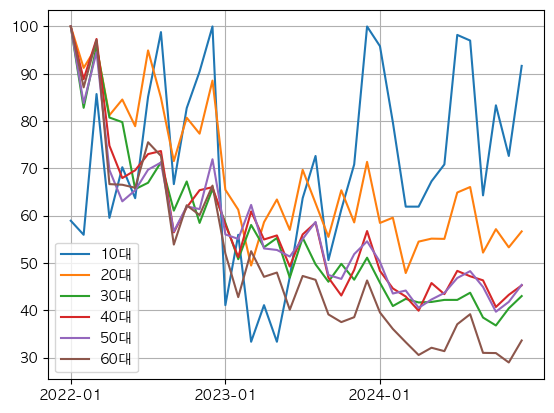

In [76]:
for age in ages:
    f1 = df_to_plot_base['age'] == age
    df_to_plot = df_to_plot_base[f1]
    df_to_plot['x'] = (df_to_plot['year']-2022)*12 + df_to_plot['month']

    x = df_to_plot['x']
    y = df_to_plot['ratio']
    plt.plot(x, y, label=age)

# Xticks
f1 = df_to_plot['x']%12 == 1
xtick_x = df_to_plot['x'][f1]
xticks = (df_to_plot['year'].astype(str) + '-'+  df_to_plot['month'].apply(lambda x: str(x).zfill(2)))[f1].to_list()

plt.xticks(xtick_x, xticks)
plt.grid()
plt.legend()

In [72]:
xtick_x

388     1
400    13
412    25
Name: x, dtype: int32

100%|██████████| 24/24 [00:01<00:00, 14.33it/s]


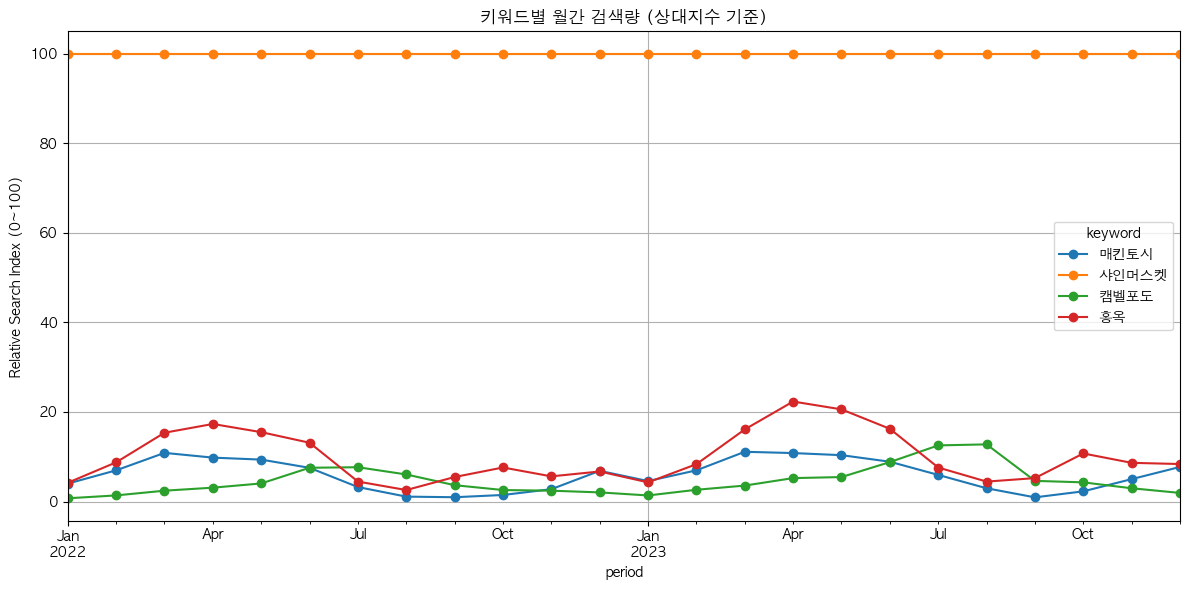

In [84]:
import requests
import json
import pandas as pd
from datetime import datetime, timedelta
from dateutil.relativedelta import relativedelta
from tqdm import tqdm
from dotenv import load_dotenv
import os
import matplotlib.pyplot as plt

# 환경 변수 로딩
load_dotenv()
client_id = os.getenv("CLIENT_ID")
client_secret = os.getenv("CLIENT_SECRET")

# 🔍 비교할 키워드 리스트
keywords = ["샤인머스켓", "캠벨포도", "홍옥", "매킨토시"]
start_month = "2022-01"
end_month = "2023-12"

# 월별 기간 생성 함수
def get_monthly_periods(start, end):
    start_dt = datetime.strptime(start, "%Y-%m")
    end_dt = datetime.strptime(end, "%Y-%m")
    periods = []
    while start_dt <= end_dt:
        s = start_dt.strftime("%Y-%m-01")
        e = (start_dt + relativedelta(months=1) - timedelta(days=1)).strftime("%Y-%m-%d")
        periods.append((s, e))
        start_dt += relativedelta(months=1)
    return periods

# 네이버 데이터랩 API 호출 함수
def fetch_monthly_data(start_date, end_date, keyword_groups):
    url = "https://openapi.naver.com/v1/datalab/search"
    headers = {
        "X-Naver-Client-Id": client_id,
        "X-Naver-Client-Secret": client_secret,
        "Content-Type": "application/json"
    }

    body = {
        "startDate": start_date,
        "endDate": end_date,
        "timeUnit": "month",
        "keywordGroups": keyword_groups
    }

    res = requests.post(url, headers=headers, data=json.dumps(body))
    if res.status_code == 200:
        results = res.json()["results"]
        flat_data = []
        for group in results:
            for item in group["data"]:
                item["keyword"] = group["title"]
                flat_data.append(item)
        return flat_data
    else:
        print(f"Error on {start_date}~{end_date}: {res.status_code}, {res.text}")
        return []

# 요청 실행
def run():
    periods = get_monthly_periods(start_month, end_month)
    results = []

    keyword_groups = [{"groupName": kw, "keywords": [kw]} for kw in keywords]

    for s, e in tqdm(periods):
        data = fetch_monthly_data(s, e, keyword_groups)
        results.extend(data)

    df = pd.DataFrame(results)
    df["period"] = pd.to_datetime(df["period"])
    pivot_df = df.pivot(index="period", columns="keyword", values="ratio")

    # 시각화
    pivot_df.plot(figsize=(12, 6), marker='o', title="키워드별 월간 검색량 (상대지수 기준)")
    plt.ylabel("Relative Search Index (0~100)")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    return pivot_df

# 실행
if __name__ == "__main__":
    df_result = run()
    # df_result.to_csv("keyword_trends.csv", encoding="utf-8-sig")


In [85]:
pip install plotly

4340.92s - pydevd: Sending message related to process being replaced timed-out after 5 seconds


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.8/14.8 MB 58.1 MB/s eta 0:00:00a 0:00:01
Note: you may need to restart the kernel to use updated packages.


In [22]:
import plotly.graph_objects as go

import requests
import json
import pandas as pd
from datetime import datetime, timedelta
from dateutil.relativedelta import relativedelta
from tqdm import tqdm
from dotenv import load_dotenv
import os
import matplotlib.pyplot as plt

# 환경 변수 로딩
load_dotenv()
client_id = os.getenv("CLIENT_ID")
client_secret = os.getenv("CLIENT_SECRET")

# 🔍 비교할 키워드 리스트
keywords = ["헬스장","피트니스","다이어트","운동","식단"]
start_month = "2022-01"
end_month = "2023-12"

In [23]:

# 월별 기간 생성 함수
def get_monthly_periods(start, end):
    start_dt = datetime.strptime(start, "%Y-%m")
    end_dt = datetime.strptime(end, "%Y-%m")
    periods = []
    while start_dt <= end_dt:
        s = start_dt.strftime("%Y-%m-01")
        e = (start_dt + relativedelta(months=1) - timedelta(days=1)).strftime("%Y-%m-%d")
        periods.append((s, e))
        start_dt += relativedelta(months=1)
    return periods

# 네이버 데이터랩 API 호출 함수
def fetch_monthly_data(start_date, end_date, keyword_groups):
    url = "https://openapi.naver.com/v1/datalab/search"
    headers = {
        "X-Naver-Client-Id": client_id,
        "X-Naver-Client-Secret": client_secret,
        "Content-Type": "application/json"
    }

    body = {
        "startDate": start_date,
        "endDate": end_date,
        "timeUnit": "month",
        "keywordGroups": keyword_groups
    }

    res = requests.post(url, headers=headers, data=json.dumps(body))
    if res.status_code == 200:
        results = res.json()["results"]
        flat_data = []
        for group in results:
            for item in group["data"]:
                item["keyword"] = group["title"]
                flat_data.append(item)
        return flat_data
    else:
        print(f"Error on {start_date}~{end_date}: {res.status_code}, {res.text}")
        return []
    

# 인터랙티브 플롯
def plot_interactive(df):
    fig = go.Figure()

    for col in df.columns:
        fig.add_trace(go.Scatter(
            x=df.index,
            y=df[col],
            mode='lines+markers',
            name=col
        ))

    fig.update_layout(
        title="키워드별 월간 검색량 (상대지수 기준)",
        xaxis_title="기간",
        yaxis_title="검색량 지수 (0~100)",
        hovermode="x unified",
        template="plotly_white",
        width=1000,
        height=600
    )

    fig.show()

# 요청 실행
def run():
    periods = get_monthly_periods(start_month, end_month)
    results = []

    keyword_groups = [{"groupName": kw, "keywords": [kw]} for kw in keywords]

    for s, e in tqdm(periods):
        data = fetch_monthly_data(s, e, keyword_groups)
        results.extend(data)

    df = pd.DataFrame(results)
    df["period"] = pd.to_datetime(df["period"])
    pivot_df = df.pivot(index="period", columns="keyword", values="ratio")
    plot_interactive(pivot_df)
    # # 시각화
    # pivot_df.plot(figsize=(12, 6), marker='o', title="키워드별 월간 검색량 (상대지수 기준)")
    # plt.ylabel("Relative Search Index (0~100)")
    # plt.grid(True)
    # plt.tight_layout()
    # plt.show()

    return pivot_df

# 실행
if __name__ == "__main__":
    df_result = run()
    # df_result.to_csv("keyword_trends.csv", encoding="utf-8-sig")


100%|██████████| 24/24 [00:03<00:00,  7.00it/s]


In [3]:
import requests
import json
import pandas as pd
from datetime import datetime, timedelta
from dateutil.relativedelta import relativedelta
from tqdm import tqdm
from dotenv import load_dotenv
import os
import plotly.graph_objects as go

# 환경 변수 로딩
load_dotenv()
client_id = os.getenv("CLIENT_ID")
client_secret = os.getenv("CLIENT_SECRET")

# 키워드 및 연령대 설정
keyword = "샤인머스켓"
ages = ["1", "2", "3", "4", "5", "6"]
start_month = "2022-01"
end_month = "2023-12"

# 월별 기간 생성 함수
def get_monthly_periods(start, end):
    start_dt = datetime.strptime(start, "%Y-%m")
    end_dt = datetime.strptime(end, "%Y-%m")
    periods = []
    while start_dt <= end_dt:
        s = start_dt.strftime("%Y-%m-01")
        e = (start_dt + relativedelta(months=1) - timedelta(days=1)).strftime("%Y-%m-%d")
        periods.append((s, e))
        start_dt += relativedelta(months=1)
    return periods

# 네이버 데이터랩 API 호출 함수 (연령별 요청)
def fetch_age_data(start_date, end_date, keyword, age):
    url = "https://openapi.naver.com/v1/datalab/search"
    headers = {
        "X-Naver-Client-Id": client_id,
        "X-Naver-Client-Secret": client_secret,
        "Content-Type": "application/json"
    }

    body = {
        "startDate": start_date,
        "endDate": end_date,
        "timeUnit": "month",
        "keywordGroups": [{"groupName": keyword, "keywords": [keyword]}],
        "ages": [age]
    }

    res = requests.post(url, headers=headers, data=json.dumps(body))
    if res.status_code == 200:
        results = res.json()["results"][0]["data"]
        for item in results:
            item["age"] = age
        return results
    else:
        print(f"Error on {start_date}~{end_date} for age {age}: {res.status_code}, {res.text}")
        return []

# 실행 함수
def run():
    periods = get_monthly_periods(start_month, end_month)
    results = []

    for s, e in tqdm(periods):
        for age in ages:
            data = fetch_age_data(s, e, keyword, age)
            results.extend(data)

    df = pd.DataFrame(results)
    df["period"] = pd.to_datetime(df["period"])
    pivot_df = df.pivot(index="period", columns="age", values="ratio")

    # 인터랙티브 그래프
    fig = go.Figure()
    for col in pivot_df.columns:
        fig.add_trace(go.Scatter(
            x=pivot_df.index,
            y=pivot_df[col],
            mode='lines+markers',
            name=f"{col}대"
        ))

    fig.update_layout(
        title=f"연령대별 '{keyword}' 검색량 추이",
        xaxis_title="기간",
        yaxis_title="검색량 지수 (0~100)",
        hovermode="x unified",
        template="plotly_white",
        width=1000,
        height=600
    )

    fig.show()
    return pivot_df

# 실행
if __name__ == "__main__":
    df_result = run()
    # df_result.to_csv("age_keyword_trends.csv", encoding="utf-8-sig")


100%|██████████| 24/24 [00:08<00:00,  2.69it/s]


---

In [22]:
df_kwds = pd.read_csv('./data/w2/wiktionary_foodlist.csv', index_col=0)

In [39]:
# 사용 예시
kwds = df_kwds['0'].to_list()
df_search = pd.DataFrame()

for i in range(1, int(len(kwds)/5+1)):
    kwds_to_search = kwds[i*5:(i+1)*5]
    df_tmp = get_search_trend(
        startDate="2023-01-01",
        endDate="2024-12-31",
        keywords=kwds_to_search
    )

    df_search = pd.concat([df_search, df_tmp])

Error: 400
{"errMsg":"TypeError: .keywordGroups -> should NOT have less than 1 items","errId":"2025-04-21T21:36:22+09:00/797615849-246834239","body":"{\"startDate\":\"2023-01-01\",\"endDate\":\"2024-12-31\",\"timeUnit\":\"date\",\"keywordGroups\":[]}"}


In [41]:
df_search.shape

(251090, 3)

In [54]:
df_search

,date,keyword,ratio
0,2023-01-01,간장,6.40865
1,2023-01-02,간장,6.79705
2,2023-01-03,간장,8.05937
3,2023-01-04,간장,7.39353
4,2023-01-05,간장,7.87904
...,...,...,...
2649,2024-11-01,희아리,1.26262
2650,2024-11-03,희아리,1.51515
2651,2024-11-14,희아리,1.51515
2652,2024-11-24,희아리,1.26262


In [44]:
df_search['keyword'].value_counts()

keyword
간장        731
양장피       731
오르되브르     731
오렌지 주스    731
오니기리      731
         ... 
삼두음         2
삼합미음        2
수타 자장       1
밥감주         1
애기젖가루       1
Name: count, Length: 393, dtype: int64

In [52]:
df_search[['keyword', 'ratio']].groupby('keyword').mean().sort_values(by='ratio', ascending=False).iloc[:20]

,ratio
keyword,
차,76.408444
국,67.296898
계란,66.062557
크림,63.618615
먹거리,61.605824
고기,61.034798
죽,60.243192
된장찌개,59.822440
마요네즈,59.731602


In [46]:
df_search[df_search['keyword'] == '오니기리']

,date,keyword,ratio
2051,2023-01-01,오니기리,42.64184
2052,2023-01-02,오니기리,51.24113
2053,2023-01-03,오니기리,56.02836
2054,2023-01-04,오니기리,49.46808
2055,2023-01-05,오니기리,52.65957
...,...,...,...
2777,2024-12-27,오니기리,41.40070
2778,2024-12-28,오니기리,49.02482
2779,2024-12-29,오니기리,48.49290
2780,2024-12-30,오니기리,46.54255


In [7]:
def collect_data_by_period(start_date, end_date, interval_days=30):
    """기간을 나누어 데이터 수집"""
    start = datetime.strptime(start_date, "%Y-%m-%d")
    end = datetime.strptime(end_date, "%Y-%m-%d")
    
    all_results = []
    current = start
    
    while current < end:
        period_end = min(current + timedelta(days=interval_days), end)
        
        # 데이터 수집
        period_data = get_shopping_insight(
            startDate=current.strftime("%Y-%m-%d"),
            endDate=period_end.strftime("%Y-%m-%d"),
            category=category
        )
        
        if period_data is not None:
            all_results.append(period_data)
        
        current = period_end + timedelta(days=1)
    
    # 모든 결과 합치기
    return pd.concat(all_results, ignore_index=True)

In [10]:
# 데이터 저장
def save_results(df, filename):
    # CSV로 저장
    df.to_csv(f"{filename}.csv", index=False, encoding='utf-8-sig')
    
    # Parquet로 저장
    df.to_parquet(f"{filename}.parquet")

# 데이터 수집 및 저장
df_shopping = collect_data_by_period("2023-01-01", "2024-03-20")
save_results(df_shopping, "naver_shopping_trends")

# 간단한 분석
def analyze_trends(df):
    # 카테고리별 평균 비율
    category_avg = df.groupby('category')['ratio'].mean()
    
    # 시간별 트렌드
    time_trend = df.pivot(index='date', columns='category', values='ratio')
    
    # 최근 30일 트렌드
    recent_trend = df[df['date'] >= (pd.Timestamp.now() - pd.Timedelta(days=30))]
    
    return {
        'category_avg': category_avg,
        'time_trend': time_trend,
        'recent_trend': recent_trend
    }

---
## [2] 쇼핑인사이트

In [ ]:
# 네이버 API 인증 정보
load_dotenv()  # .env 파일 로드
client_id = os.getenv("CLIENT_ID")
client_secret = os.getenv("CLIENT_SECRET")

# 헤더 설정
headers = {
    "X-Naver-Client-Id": client_id,
    "X-Naver-Client-Secret": client_secret,
    "Content-Type": "application/json"
}


In [ ]:
def get_shopping_insight(startDate, endDate, category, timeUnit='date', device='pc', gender='f', ages=['20', '30']):
    url = "https://openapi.naver.com/v1/datalab/shopping/categories"
    
    body = {
        "startDate": startDate,
        "endDate": endDate,
        "timeUnit": timeUnit,
        "category": category,
        "device": device,
        "gender": gender,
        "ages": ages
    }
    
    response = requests.post(url, headers=headers, data=json.dumps(body))
    
    if response.status_code == 200:
        data = response.json()
        # DataFrame으로 변환
        results = []
        for item in data['results']:
            for datum in item['data']:
                results.append({
                    'date': datum['period'],
                    'category': item['title'],
                    'ratio': datum['ratio']
                })
        return pd.DataFrame(results)
    else:
        print(f"Error: {response.status_code}")
        print(response.text)
        return None

# 사용 예시
category = [
    {"name": "건강기능식품", "param": ["50000000"]},
    # {"name": "화장품/미용", "param": ["50000002"]}
]

df_shopping = get_shopping_insight(
    startDate="2024-01-01",
    endDate="2024-03-20",
    category=category
)

## [3] 연관검색어

In [62]:
import requests
import json
import pandas as pd
import numpy as np
from collections import Counter
import time
from tqdm import tqdm

plt.rcParams['font.family'] = 'AppleGothic'

class NaverKeywordAnalyzer:
    def __init__(self, client_id, client_secret):
        self.client_id = client_id
        self.client_secret = client_secret
        self.headers = {
            "X-Naver-Client-Id": client_id,
            "X-Naver-Client-Secret": client_secret,
            "Content-Type": "application/json"
        }

    def get_trend_data(self, keywords, start_date, end_date):
        """데이터랩 API로 트렌드 데이터 가져오기 (5개 단위로 분할)"""
        all_results = []
        
        # 키워드를 5개씩 분할
        for i in range(0, len(keywords), 5):
            chunk_keywords = keywords[i:i+5]
            
            body = {
                "startDate": start_date,
                "endDate": end_date,
                "timeUnit": "month",
                "keywordGroups": [
                    {
                        "groupName": keyword,
                        "keywords": [keyword]
                    } for keyword in chunk_keywords
                ]
            }
            
            try:
                response = requests.post(
                    "https://openapi.naver.com/v1/datalab/search",
                    headers=self.headers,
                    data=json.dumps(body)
                )
                
                if response.status_code == 200:
                    result = response.json()
                    if 'results' in result:
                        all_results.extend(result['results'])
                else:
                    print(f"Error {response.status_code}: {response.text}")
                
                # API 호출 제한 고려
                time.sleep(1)
                
            except Exception as e:
                print(f"Error: {str(e)}")
        
        return {"results": all_results} if all_results else None

    def find_related_keywords(self, seed_keyword, max_depth=2, min_correlation=0.3):
        """연관 키워드 찾기"""
        processed_keywords = set()
        related_keywords = []
        
        def process_keyword(keyword, depth):
            if depth > max_depth or keyword in processed_keywords:
                return
            
            processed_keywords.add(keyword)
            print(f"Processing: {keyword} (depth {depth})")
            
            # 검색 API로 연관 키워드 찾기
            url = f"https://openapi.naver.com/v1/search/shop.json"
            params = {"query": keyword, "display": 100}
            
            try:
                response = requests.get(url, headers=self.headers, params=params)
                if response.status_code == 200:
                    items = response.json().get('items', [])
                    
                    # 제목에서 키워드 추출
                    keywords = []
                    for item in items:
                        title = item['title'].replace('<b>', '').replace('</b>', '')
                        words = [w for w in title.split() if len(w) > 1]
                        keywords.extend(words)
                    
                    # 상위 빈도 키워드 선택
                    keyword_freq = Counter(keywords)
                    top_keywords = [k for k, v in keyword_freq.most_common(5)]
                    
                    if top_keywords:
                        related_keywords.extend(top_keywords)
                        
                        # 재귀적으로 처리
                        if depth < max_depth:
                            for related_keyword in top_keywords:
                                time.sleep(1)  # API 호출 제한
                                process_keyword(related_keyword, depth + 1)
                
                time.sleep(1)  # API 호출 제한
                
            except Exception as e:
                print(f"Error: {str(e)}")
        
        # 시작 키워드로부터 연관 키워드 찾기
        process_keyword(seed_keyword, 0)
        
        # 중복 제거 및 최대 20개 키워드 선택
        unique_keywords = list(dict.fromkeys(related_keywords))[:20]
        
        # 트렌드 데이터 수집 및 상관관계 분석
        trend_data = self.get_trend_data(
            [seed_keyword] + unique_keywords,
            "2023-01-01",
            "2024-03-31"
        )
        
        if trend_data and 'results' in trend_data:
            # 트렌드 데이터를 DataFrame으로 변환
            trends = {}
            for result in trend_data['results']:
                trends[result['title']] = [d['ratio'] for d in result['data']]
            
            df_trends = pd.DataFrame(trends)
            
            # 상관관계 계산
            correlations = df_trends.corr()[seed_keyword].sort_values(ascending=False)
            
            # 상관관계가 높은 키워드만 선택
            related_with_corr = correlations[correlations >= min_correlation]
            
            return pd.DataFrame({
                'keyword': related_with_corr.index,
                'correlation': related_with_corr.values
            })
        
        return pd.DataFrame()

def main():
    load_dotenv()  # .env 파일 로드
    client_id = os.getenv("CLIENT_ID")
    client_secret = os.getenv("CLIENT_SECRET")
    
    analyzer = NaverKeywordAnalyzer(client_id, client_secret)
    
    # 건강식 관련 키워드 분석
    seed_keyword = "건강식품"
    results = analyzer.find_related_keywords(
        seed_keyword,
        max_depth=2,
        min_correlation=0.3
    )
    
    if not results.empty:
        print("\n=== 연관 키워드 분석 결과 ===")
        print(results.to_string(index=False))
        
        # 결과 저장
        results.to_csv(f'{seed_keyword}_related_keywords.csv', 
                      index=False, 
                      encoding='utf-8-sig')
        
        # 시각화
        plt.figure(figsize=(12, 6))
        plt.barh(results['keyword'], results['correlation'])
        plt.title(f"'{seed_keyword}'의 연관 키워드 상관관계")
        plt.xlabel('상관계수')
        plt.ylabel('키워드')
        plt.tight_layout()
        plt.show()

if __name__ == "__main__":
    main()

Processing: 건강식품 (depth 0)
Processing: 유산균 (depth 1)
Processing: 프로바이오틱스 (depth 2)
Processing: 1개 (depth 2)
Processing: 3개 (depth 2)
Processing: 60캡슐, (depth 2)
Processing: 락토핏 (depth 1)
Processing: 생유산균 (depth 2)
Processing: 2g (depth 2)
Processing: 종근당건강 (depth 2)


ValueError: All arrays must be of the same length